**HOUSE PRICE PREDICTION**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style

In [43]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

In [6]:
def root_mean_squared_log_error(y_valid, y_preds):
    """Calculate root mean squared error of log(y_true) and log(y_pred)"""
    if len(y_preds)!=len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new, y_preds_new, squared=False)

**Data Loading and Quick Checks**




Initial Data Load and Analysis

In [7]:
house_data = pd.read_csv('train_house.csv')
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
house_data.shape

(1460, 81)

In [9]:
print(house_data.columns[house_data.isna().any()].tolist())
len(house_data.columns[house_data.isna().any()].tolist())

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


19

**Imputation Decision**
19 of the 80 features are missing some values. I've decided to just use simple imputation to fill them in, rather than a unique solution for each feature.

**EDA**

In [11]:
import seaborn as sns

Here in matplotlib you can change the default rc setting by using rcParams

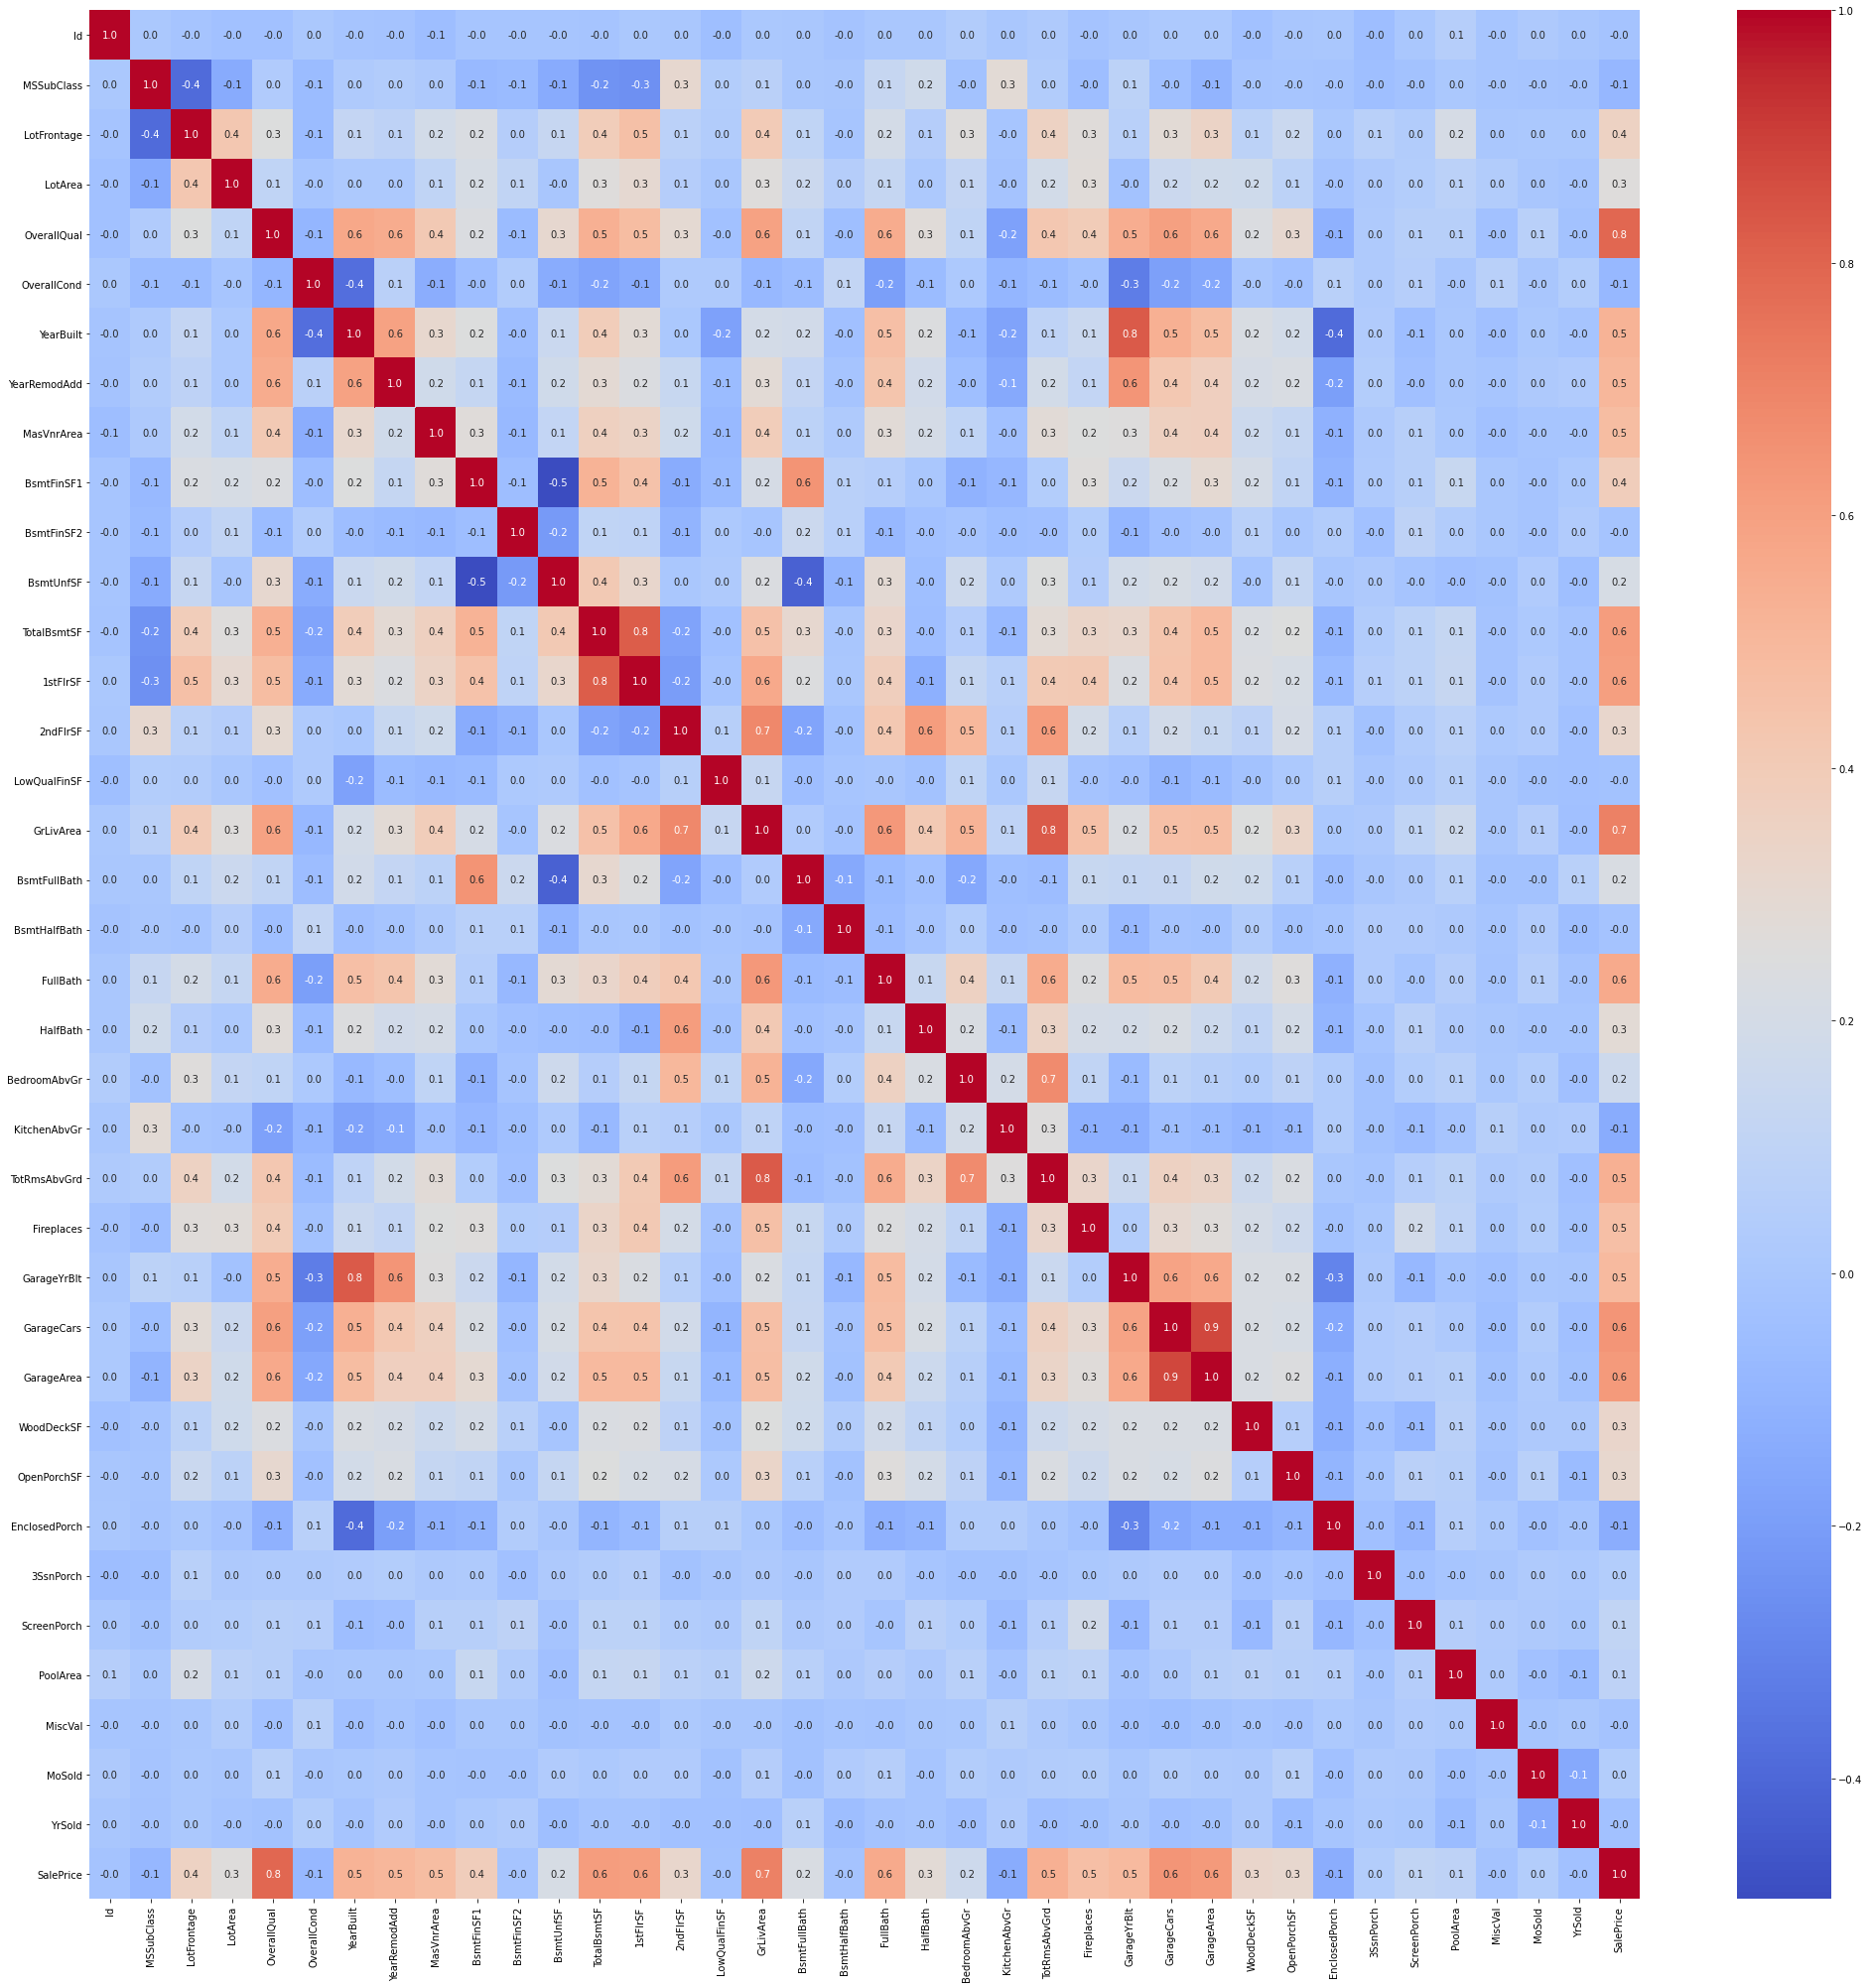

In [17]:
plt.rcParams['figure.figsize']=35,35
g = sns.heatmap(house_data.corr(),annot=True, fmt = ".1f", cmap = "coolwarm" )

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

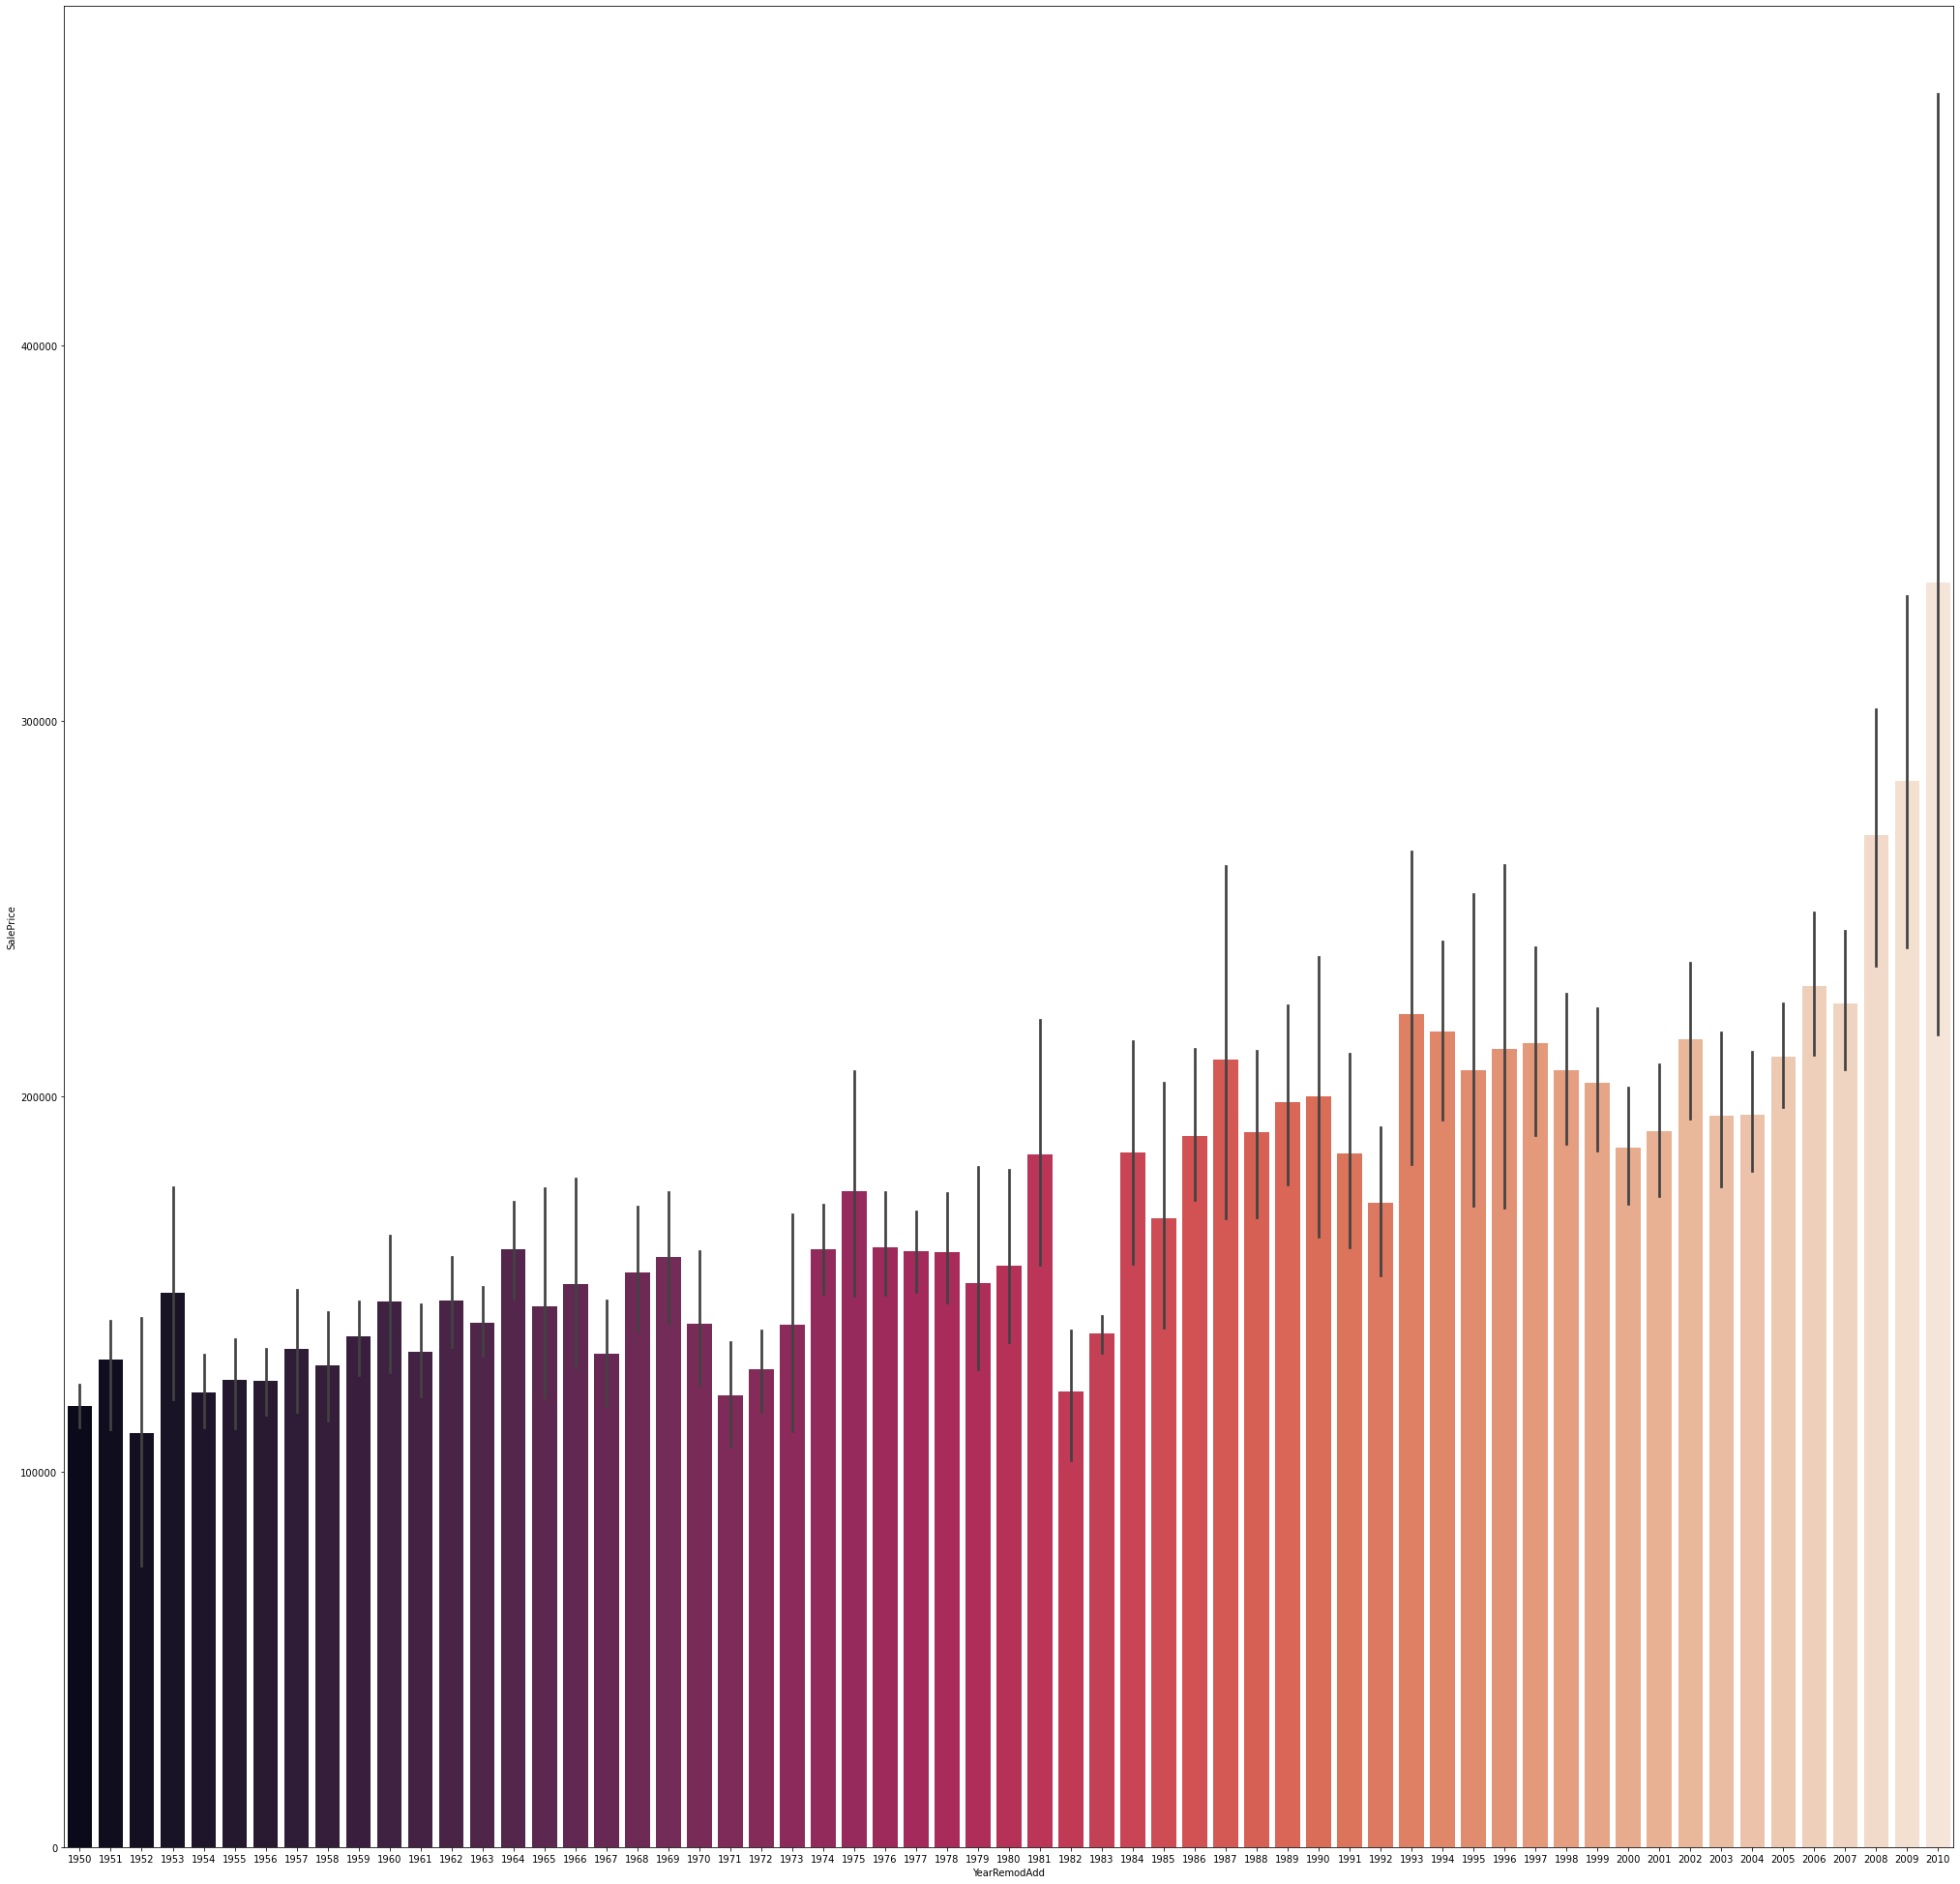

In [18]:
sns.barplot(x='YearRemodAdd', y='SalePrice', data=house_data, palette="rocket")

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

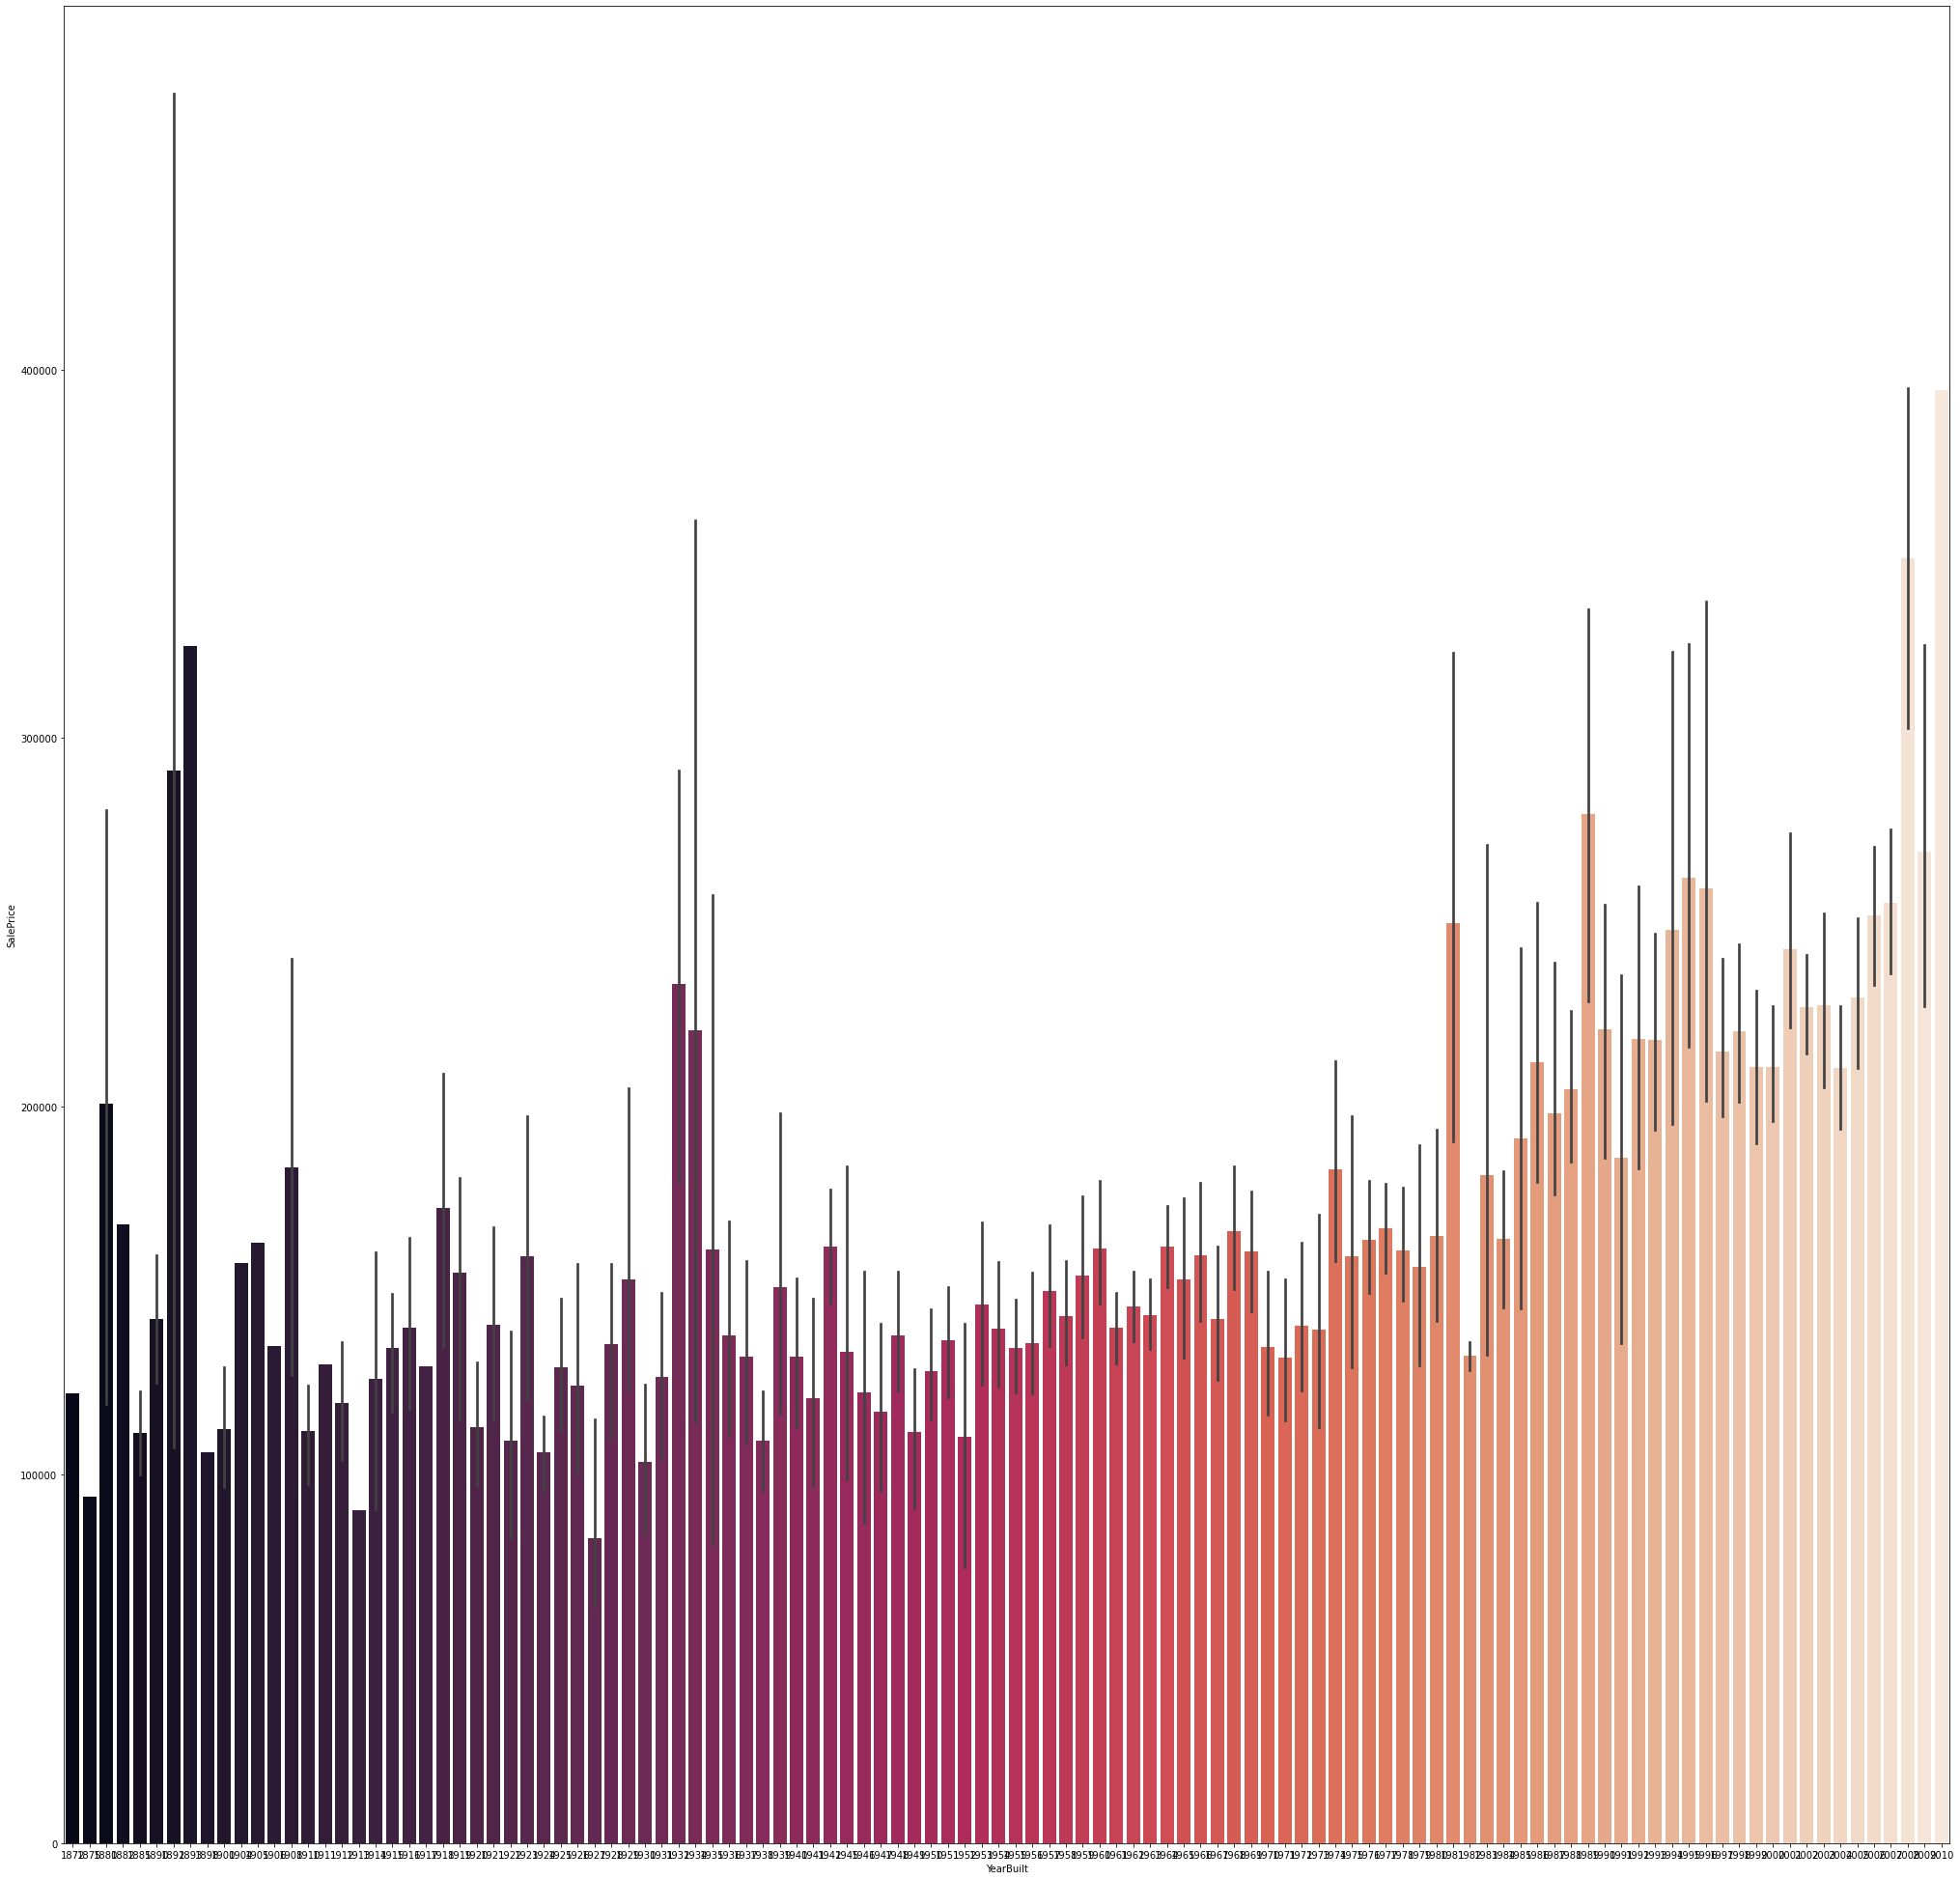

In [15]:
sns.barplot(x='YearBuilt', y='SalePrice', data=house_data, palette="rocket")

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

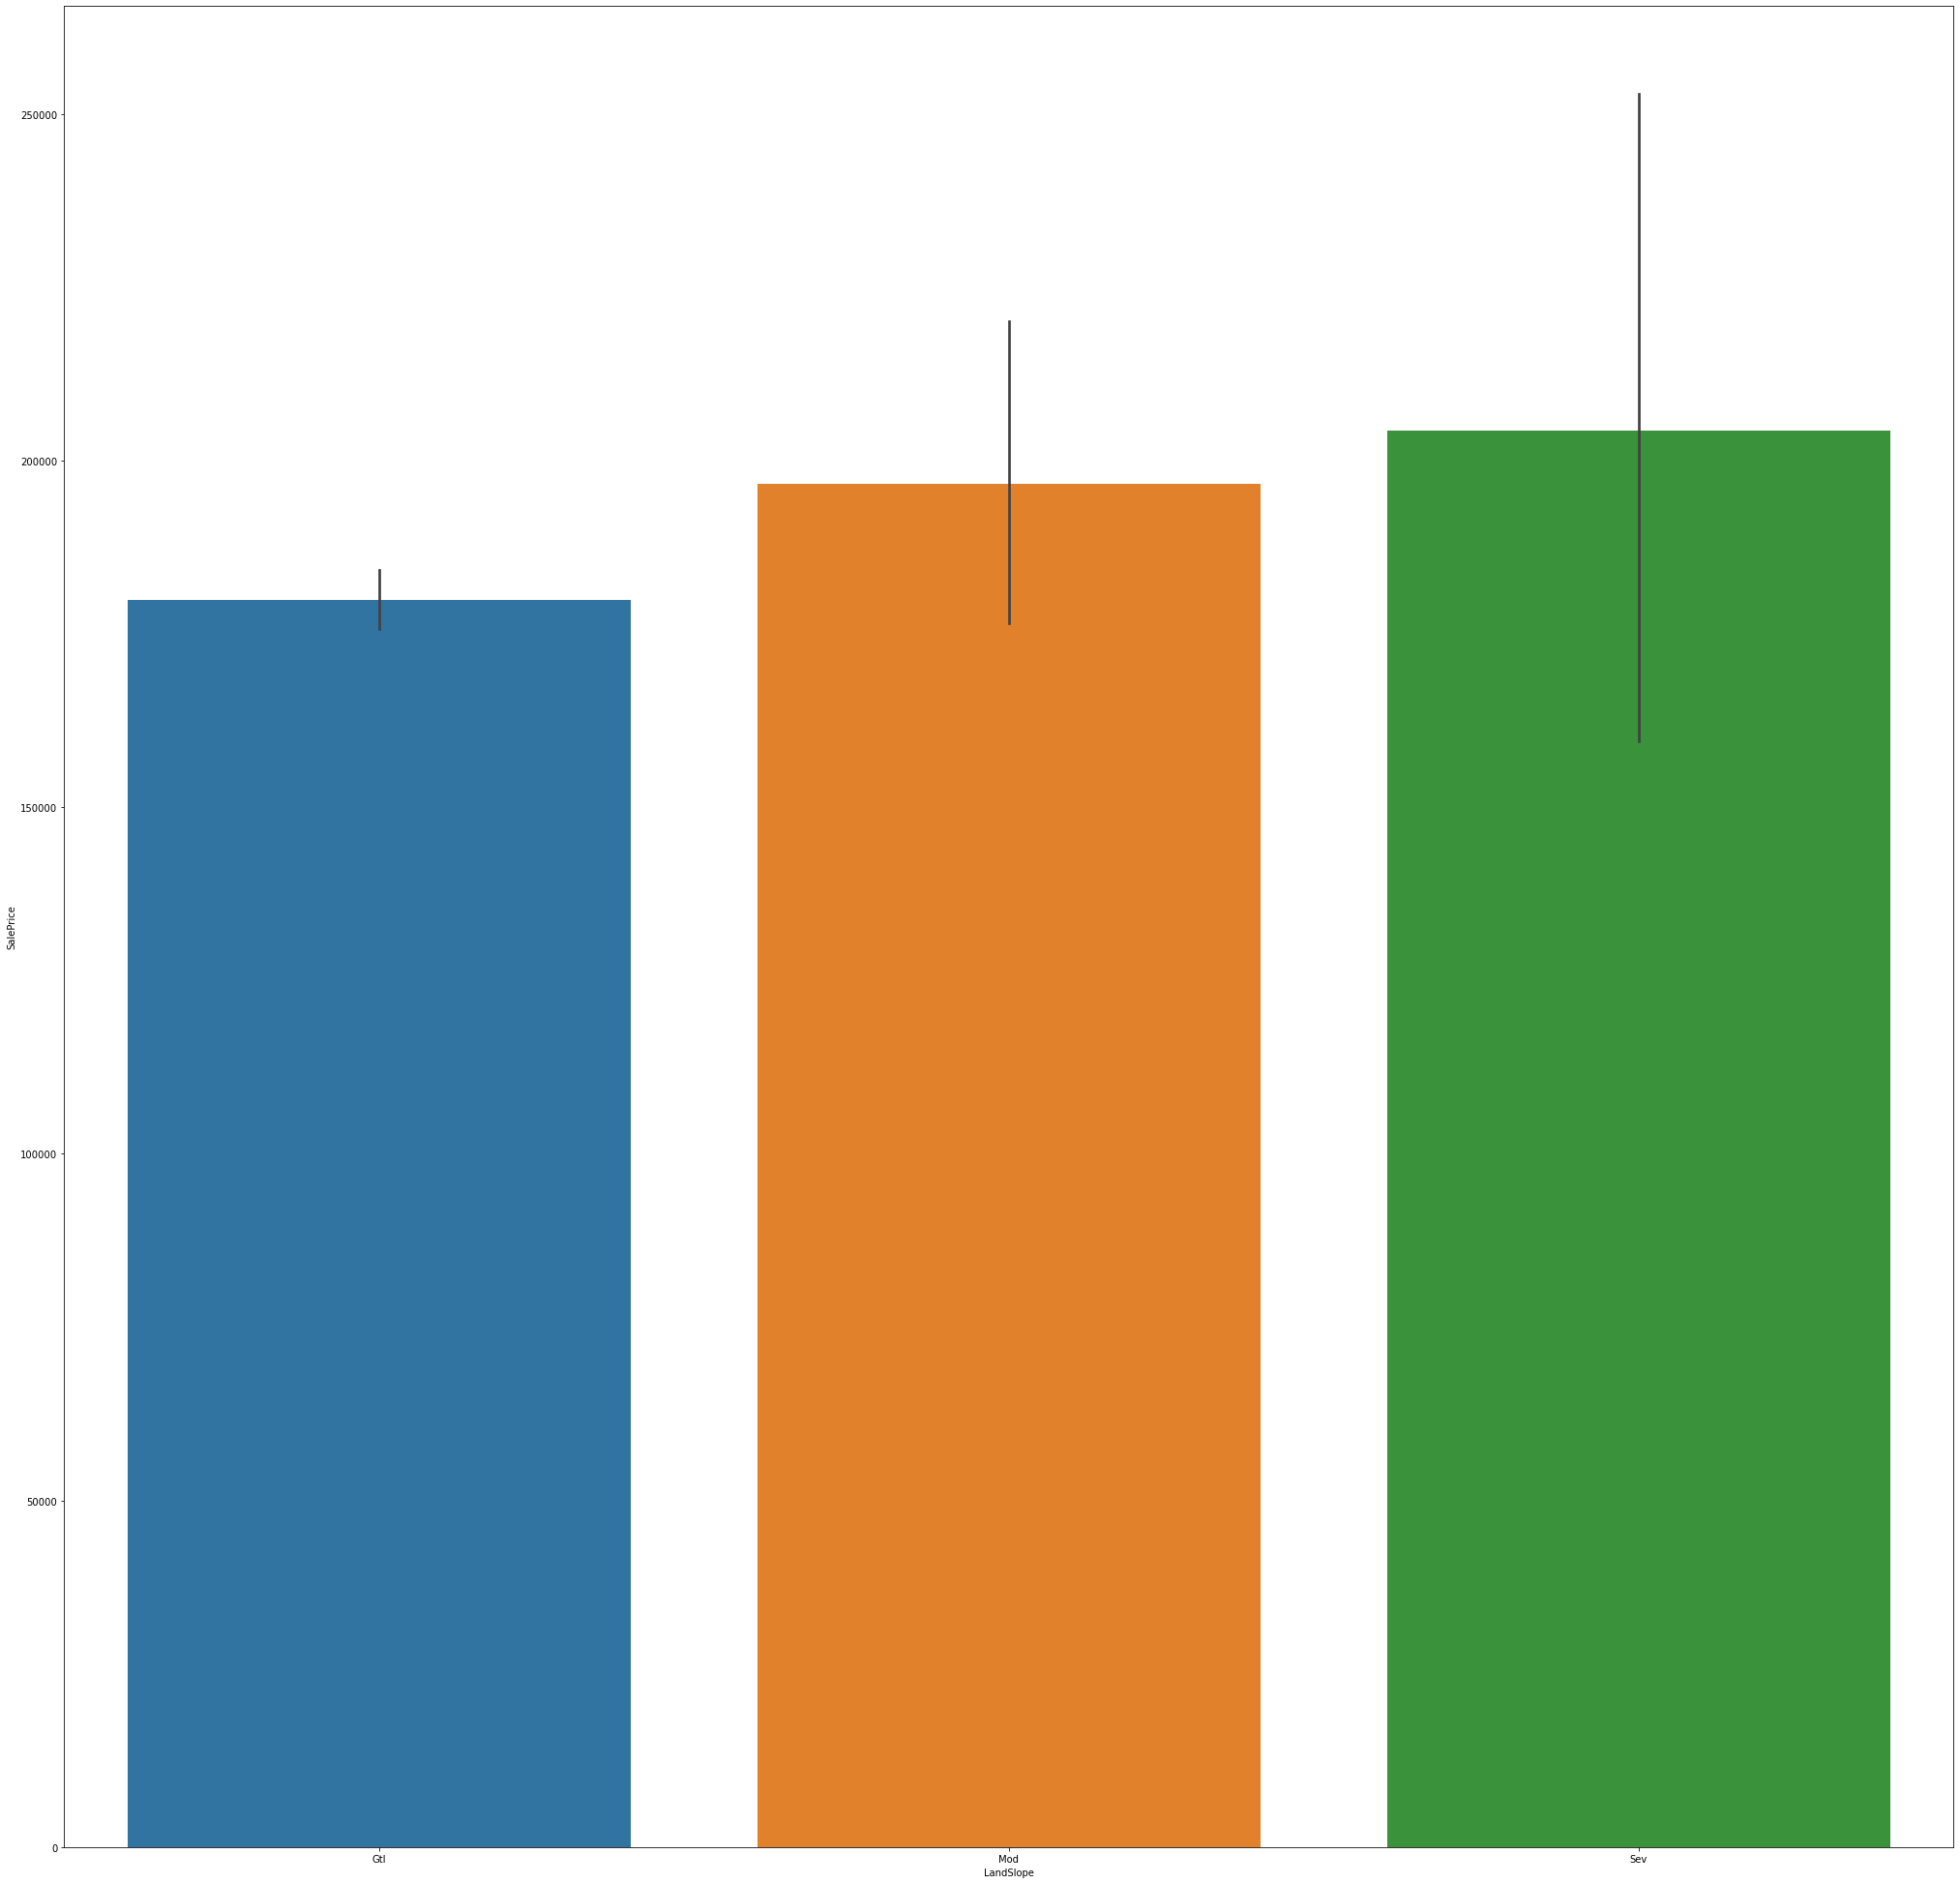

In [19]:
sns.barplot(x='LandSlope', y='SalePrice', data=house_data)

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

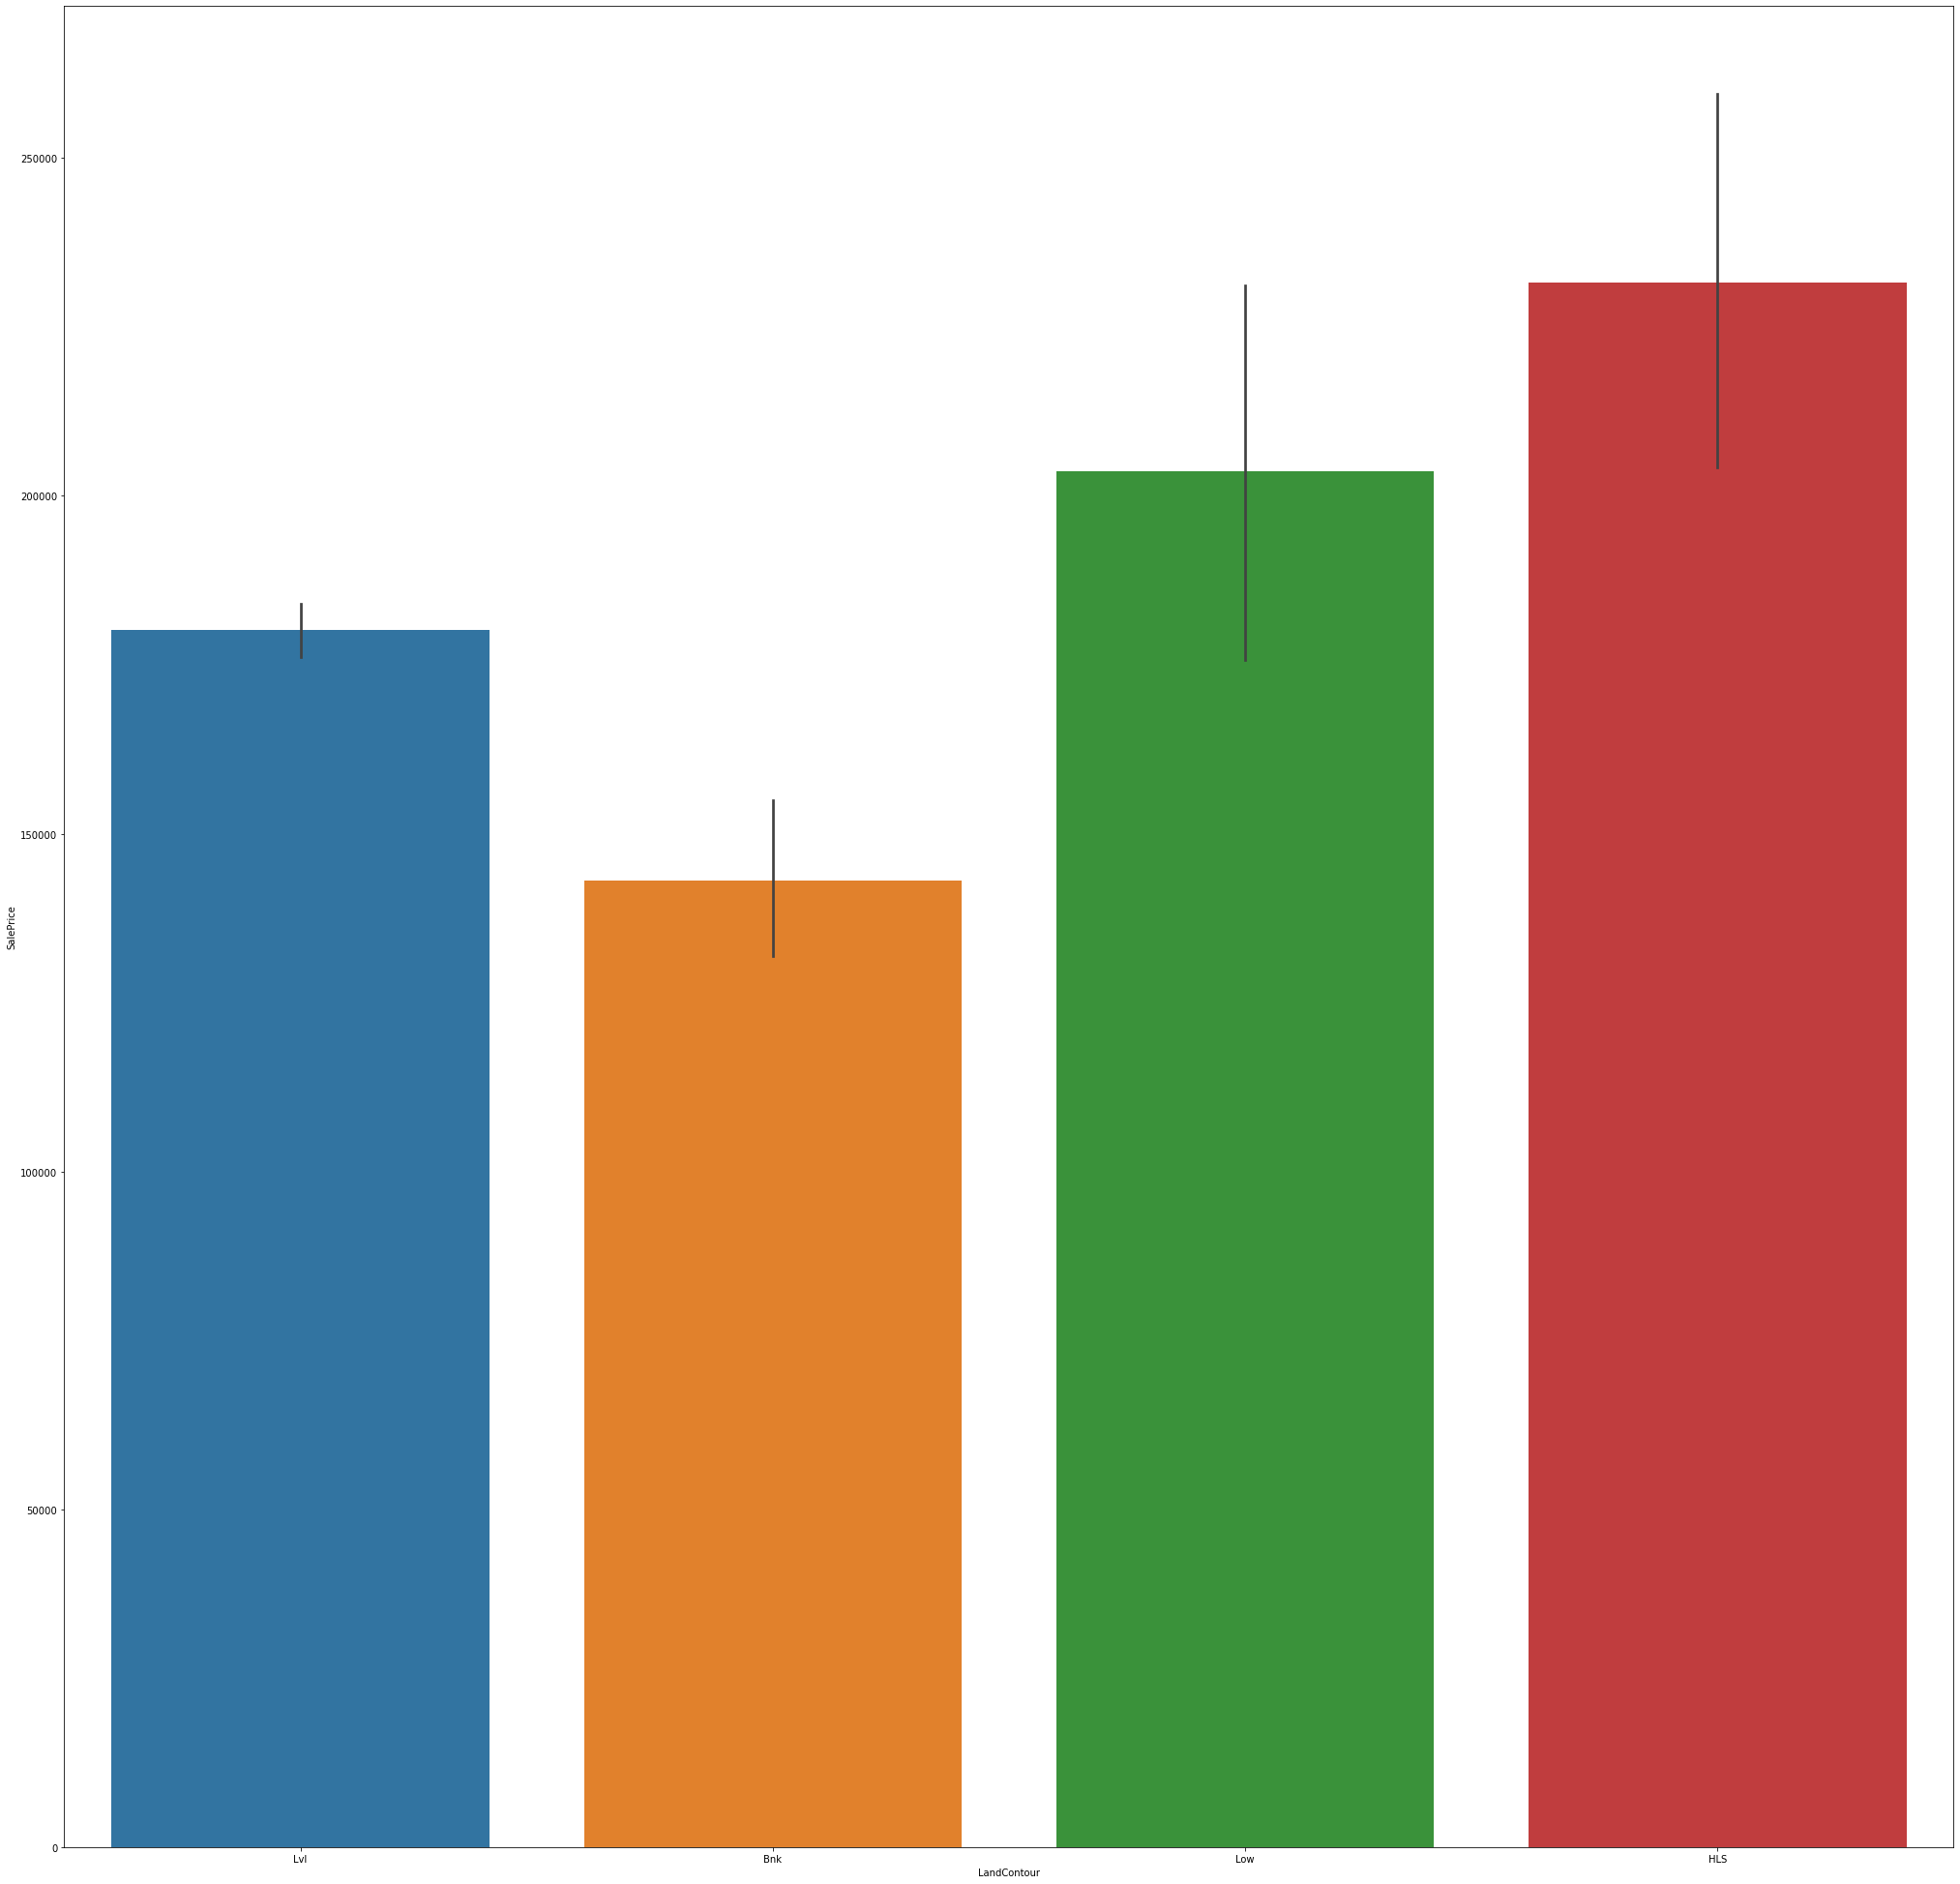

In [20]:
sns.barplot(x='LandContour', y='SalePrice', data=house_data)


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

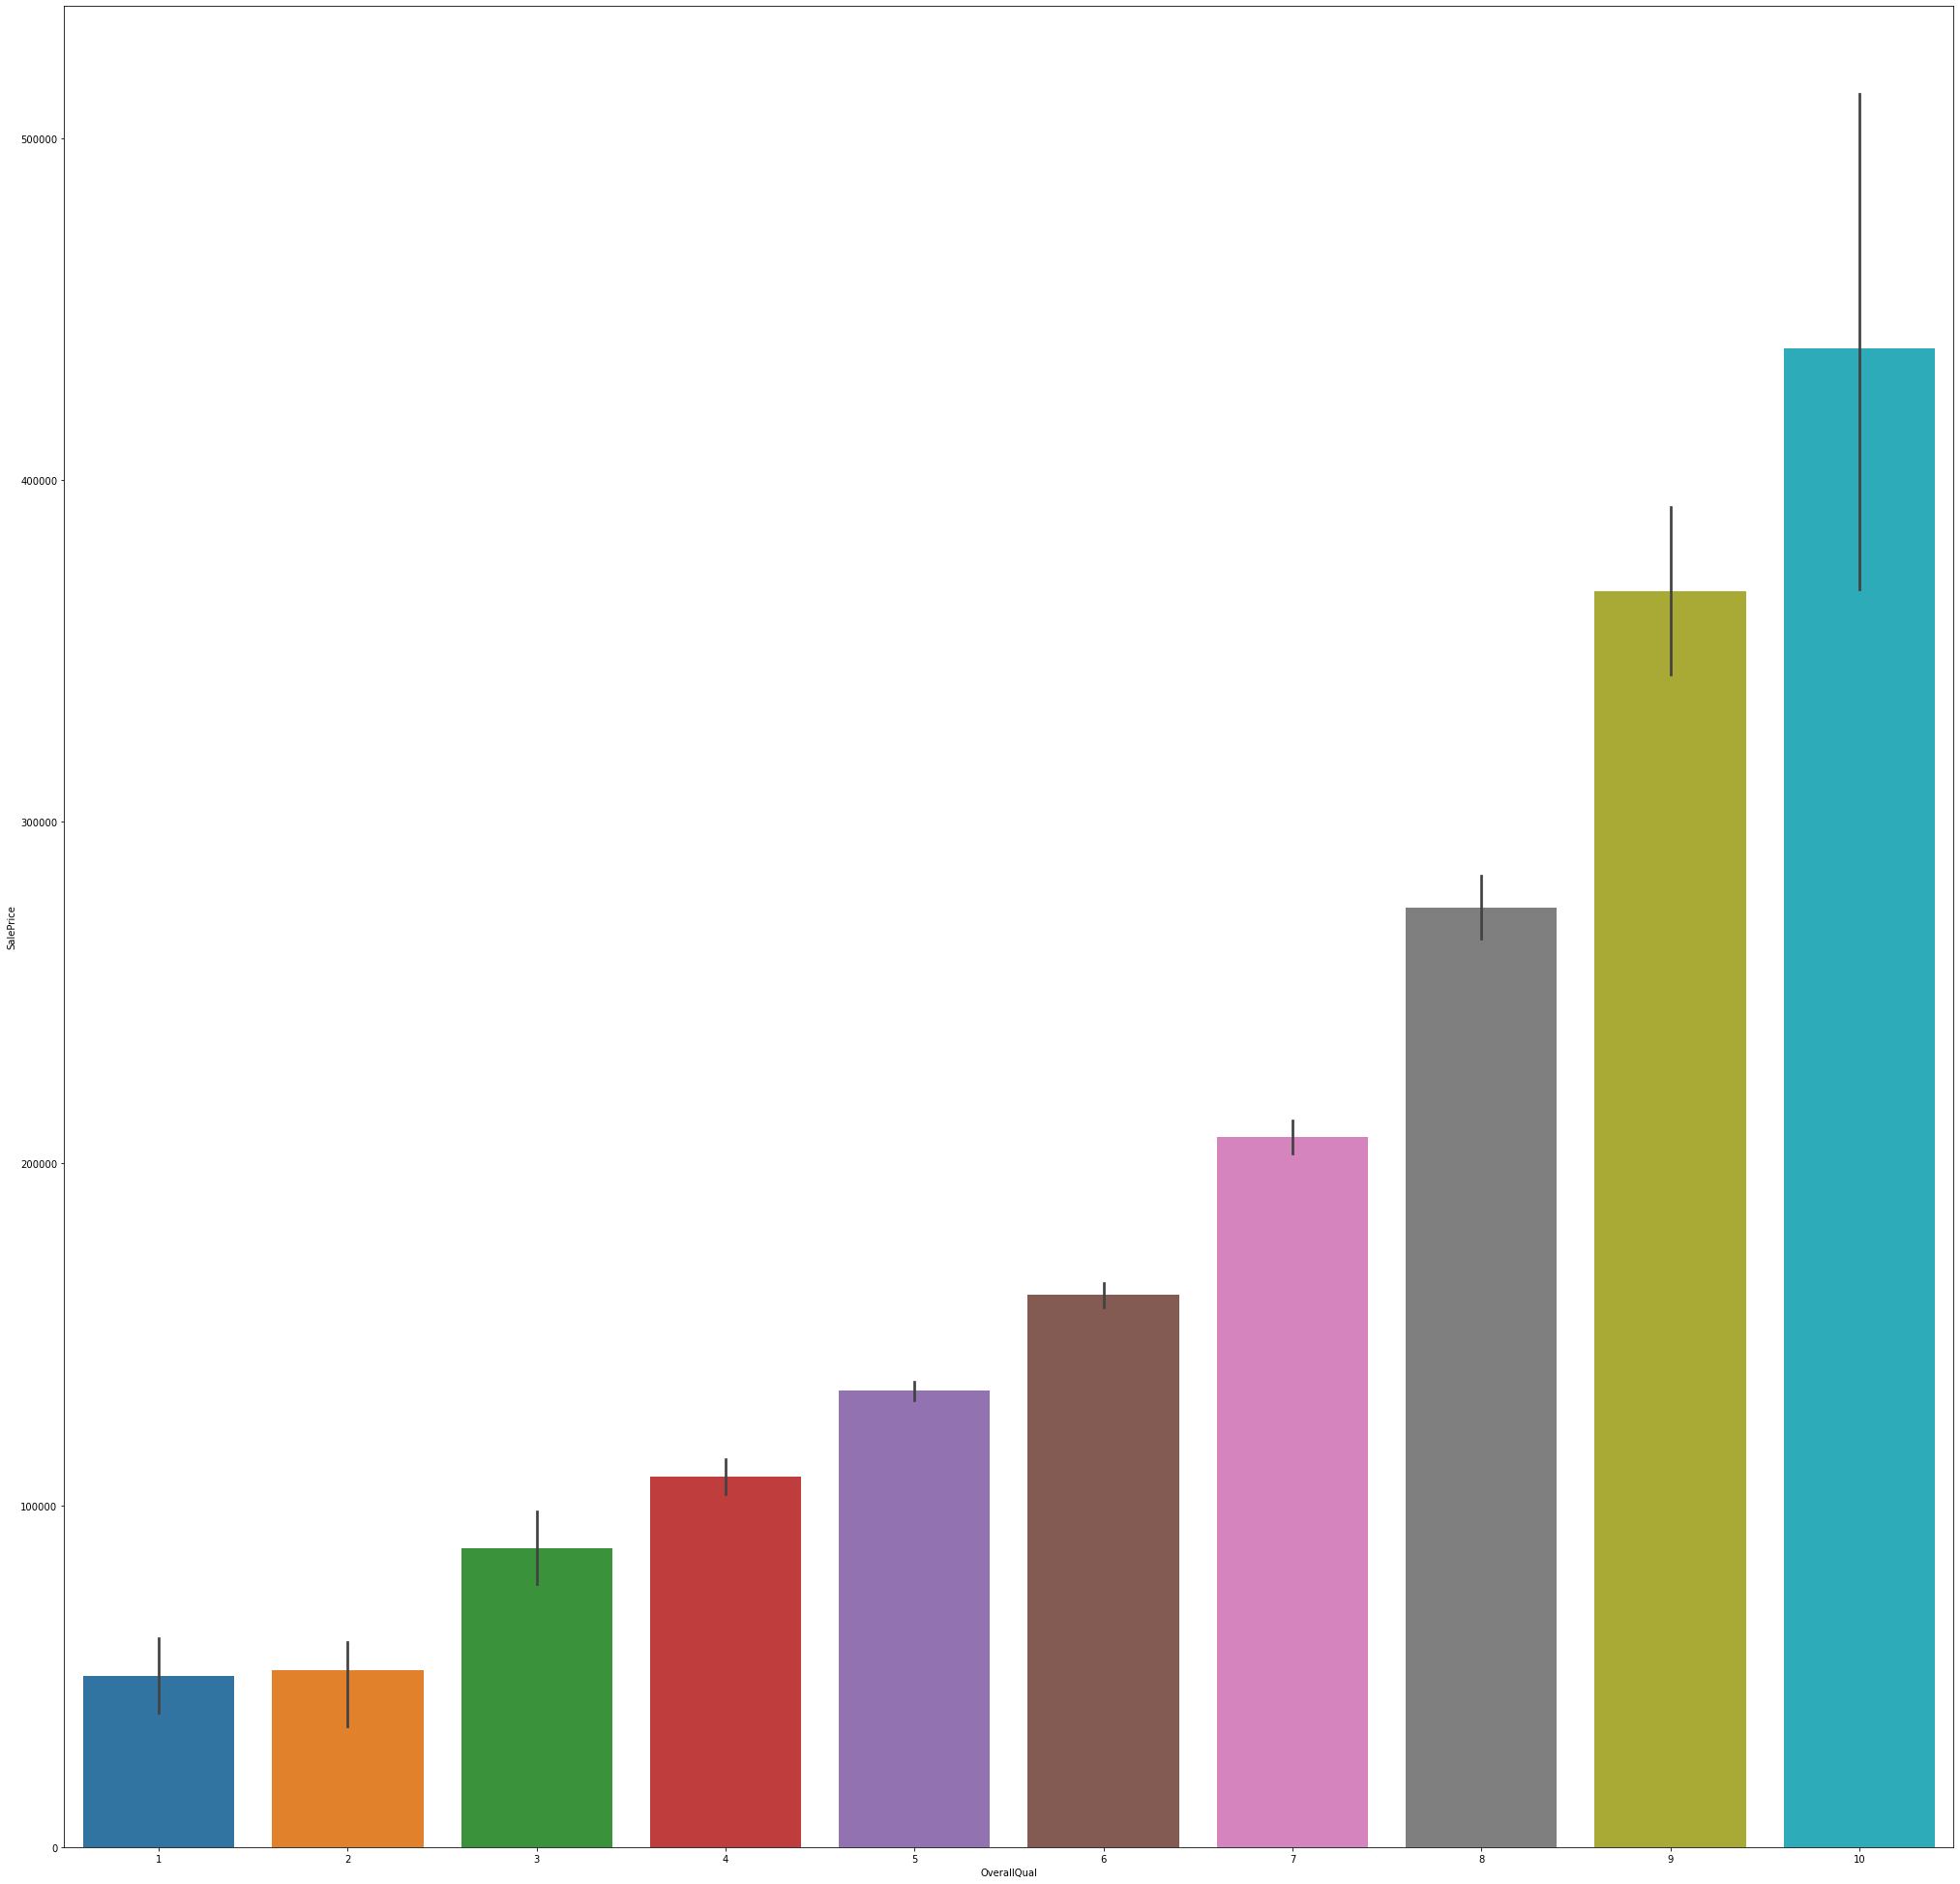

In [21]:
sns.barplot(x='OverallQual', y='SalePrice', data=house_data)


<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

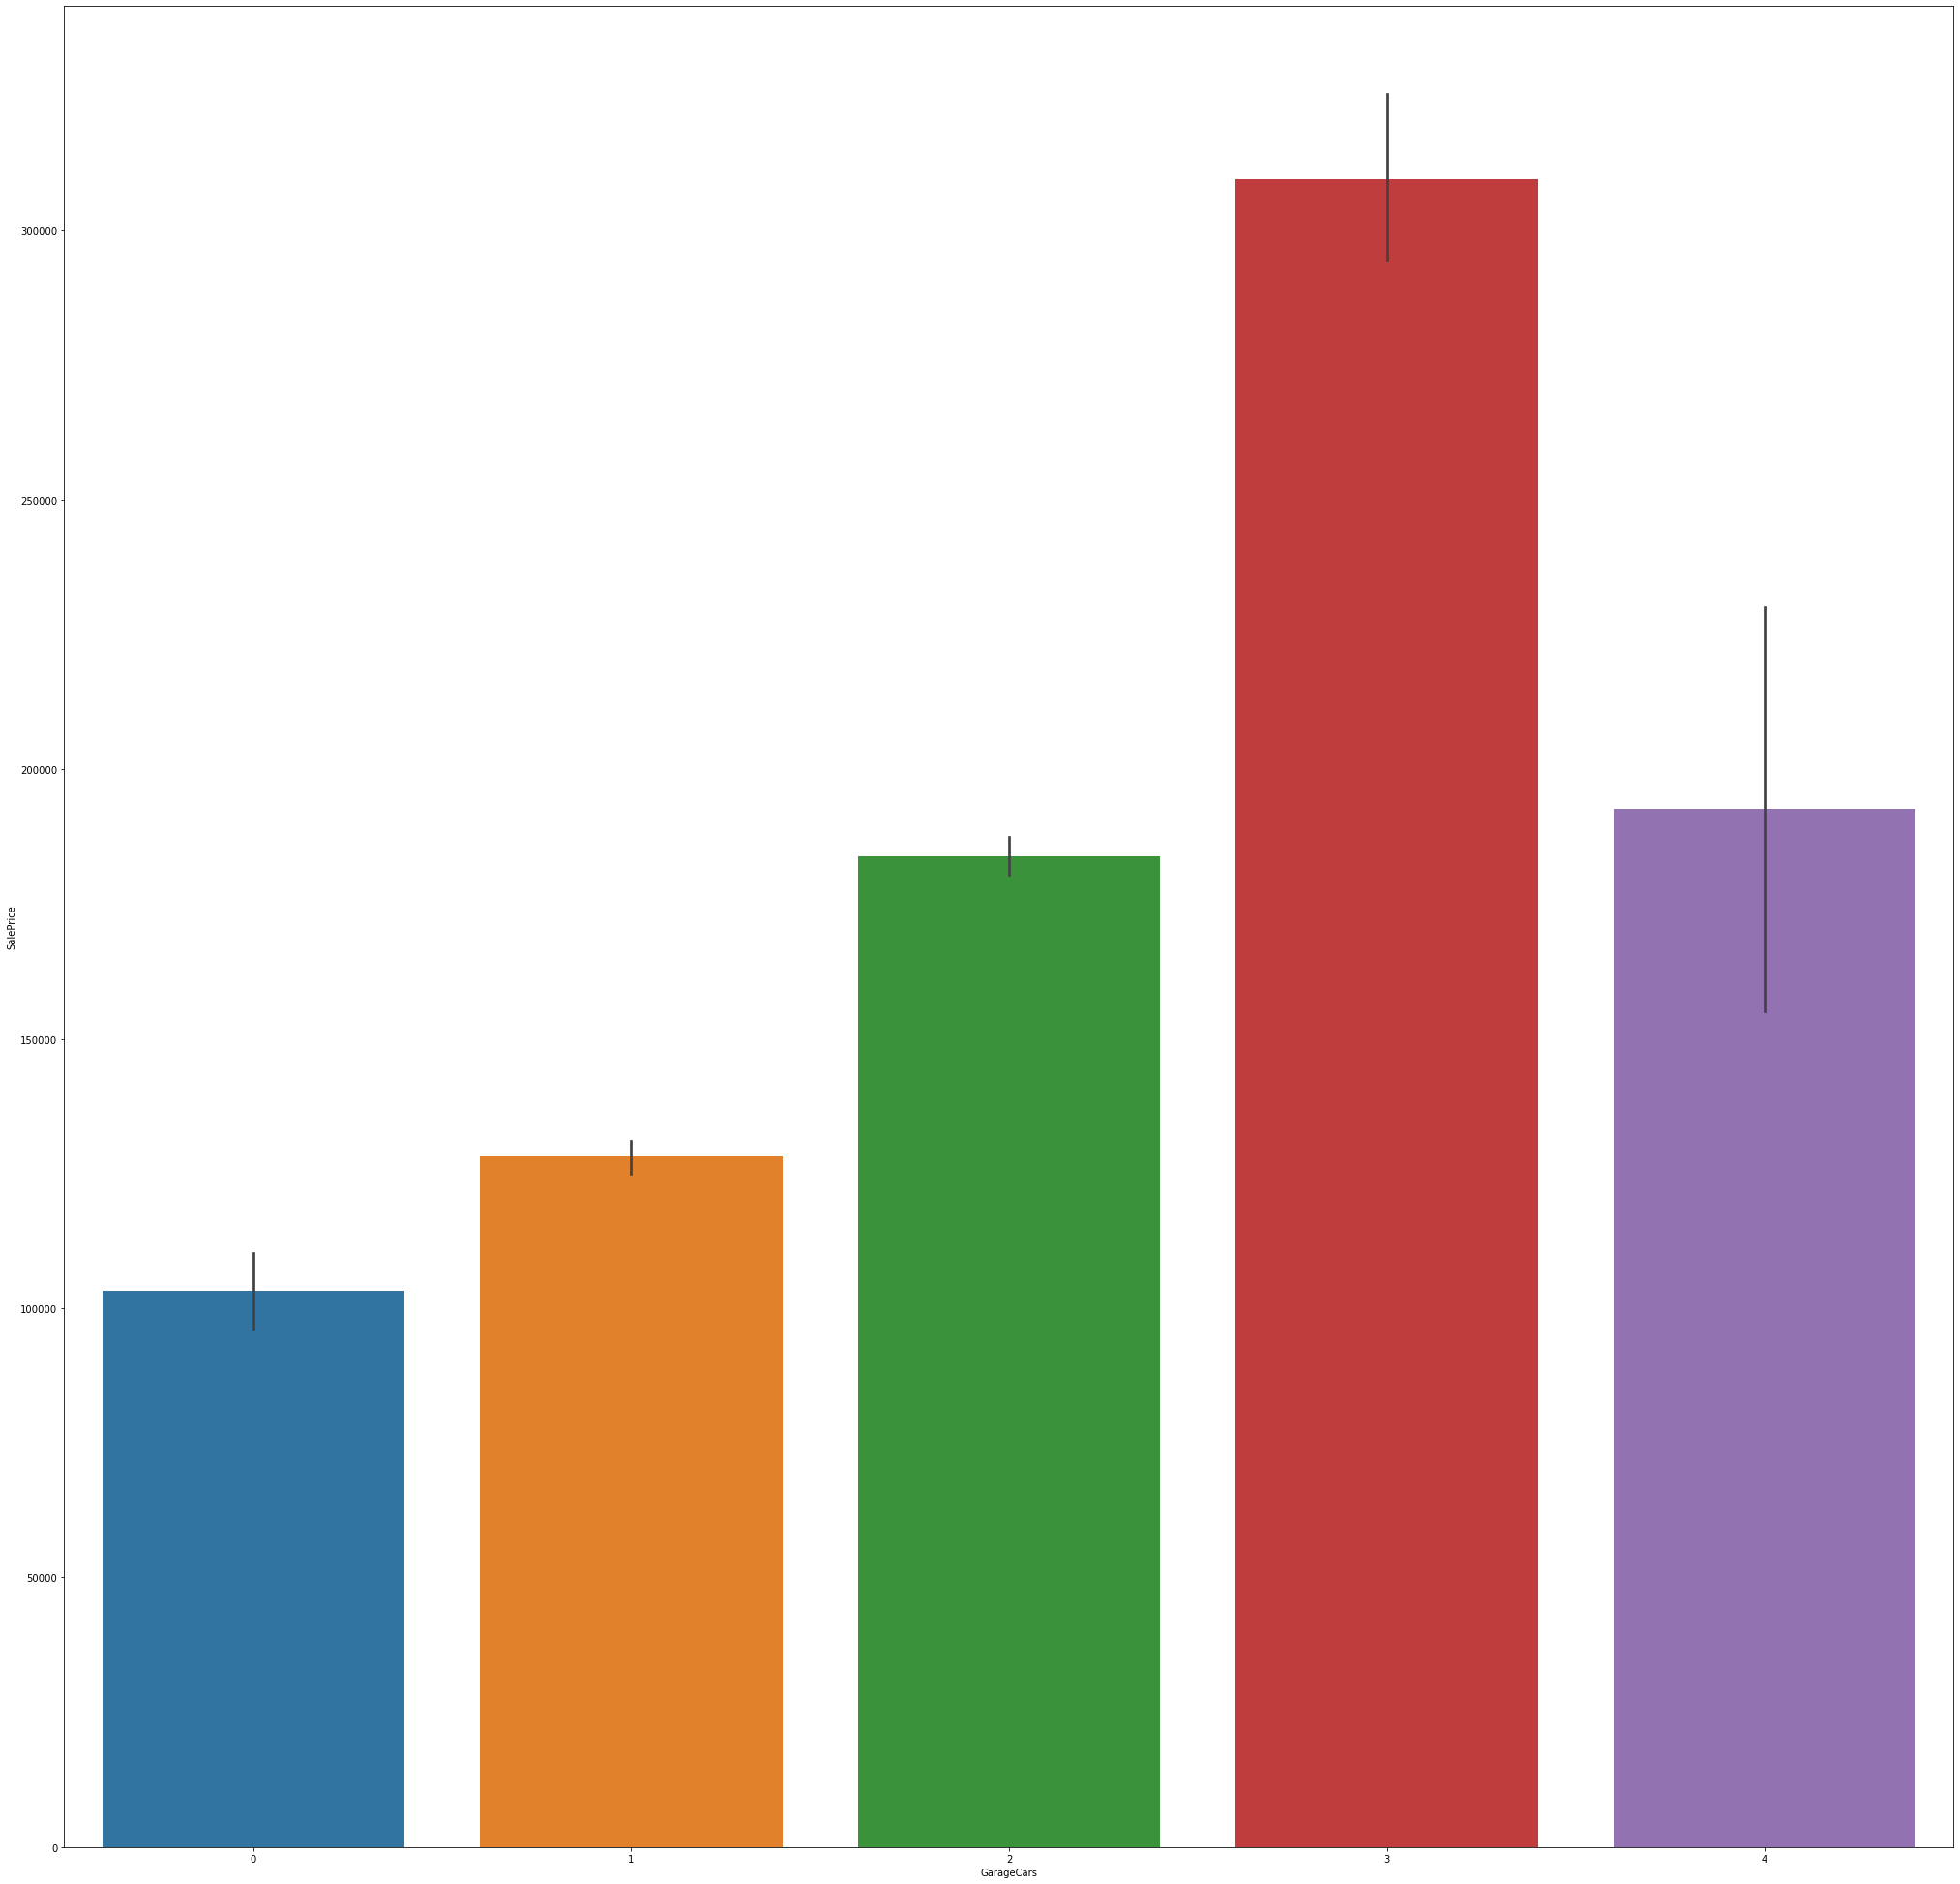

In [22]:
sns.barplot(x='GarageCars', y='SalePrice', data=house_data)


<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

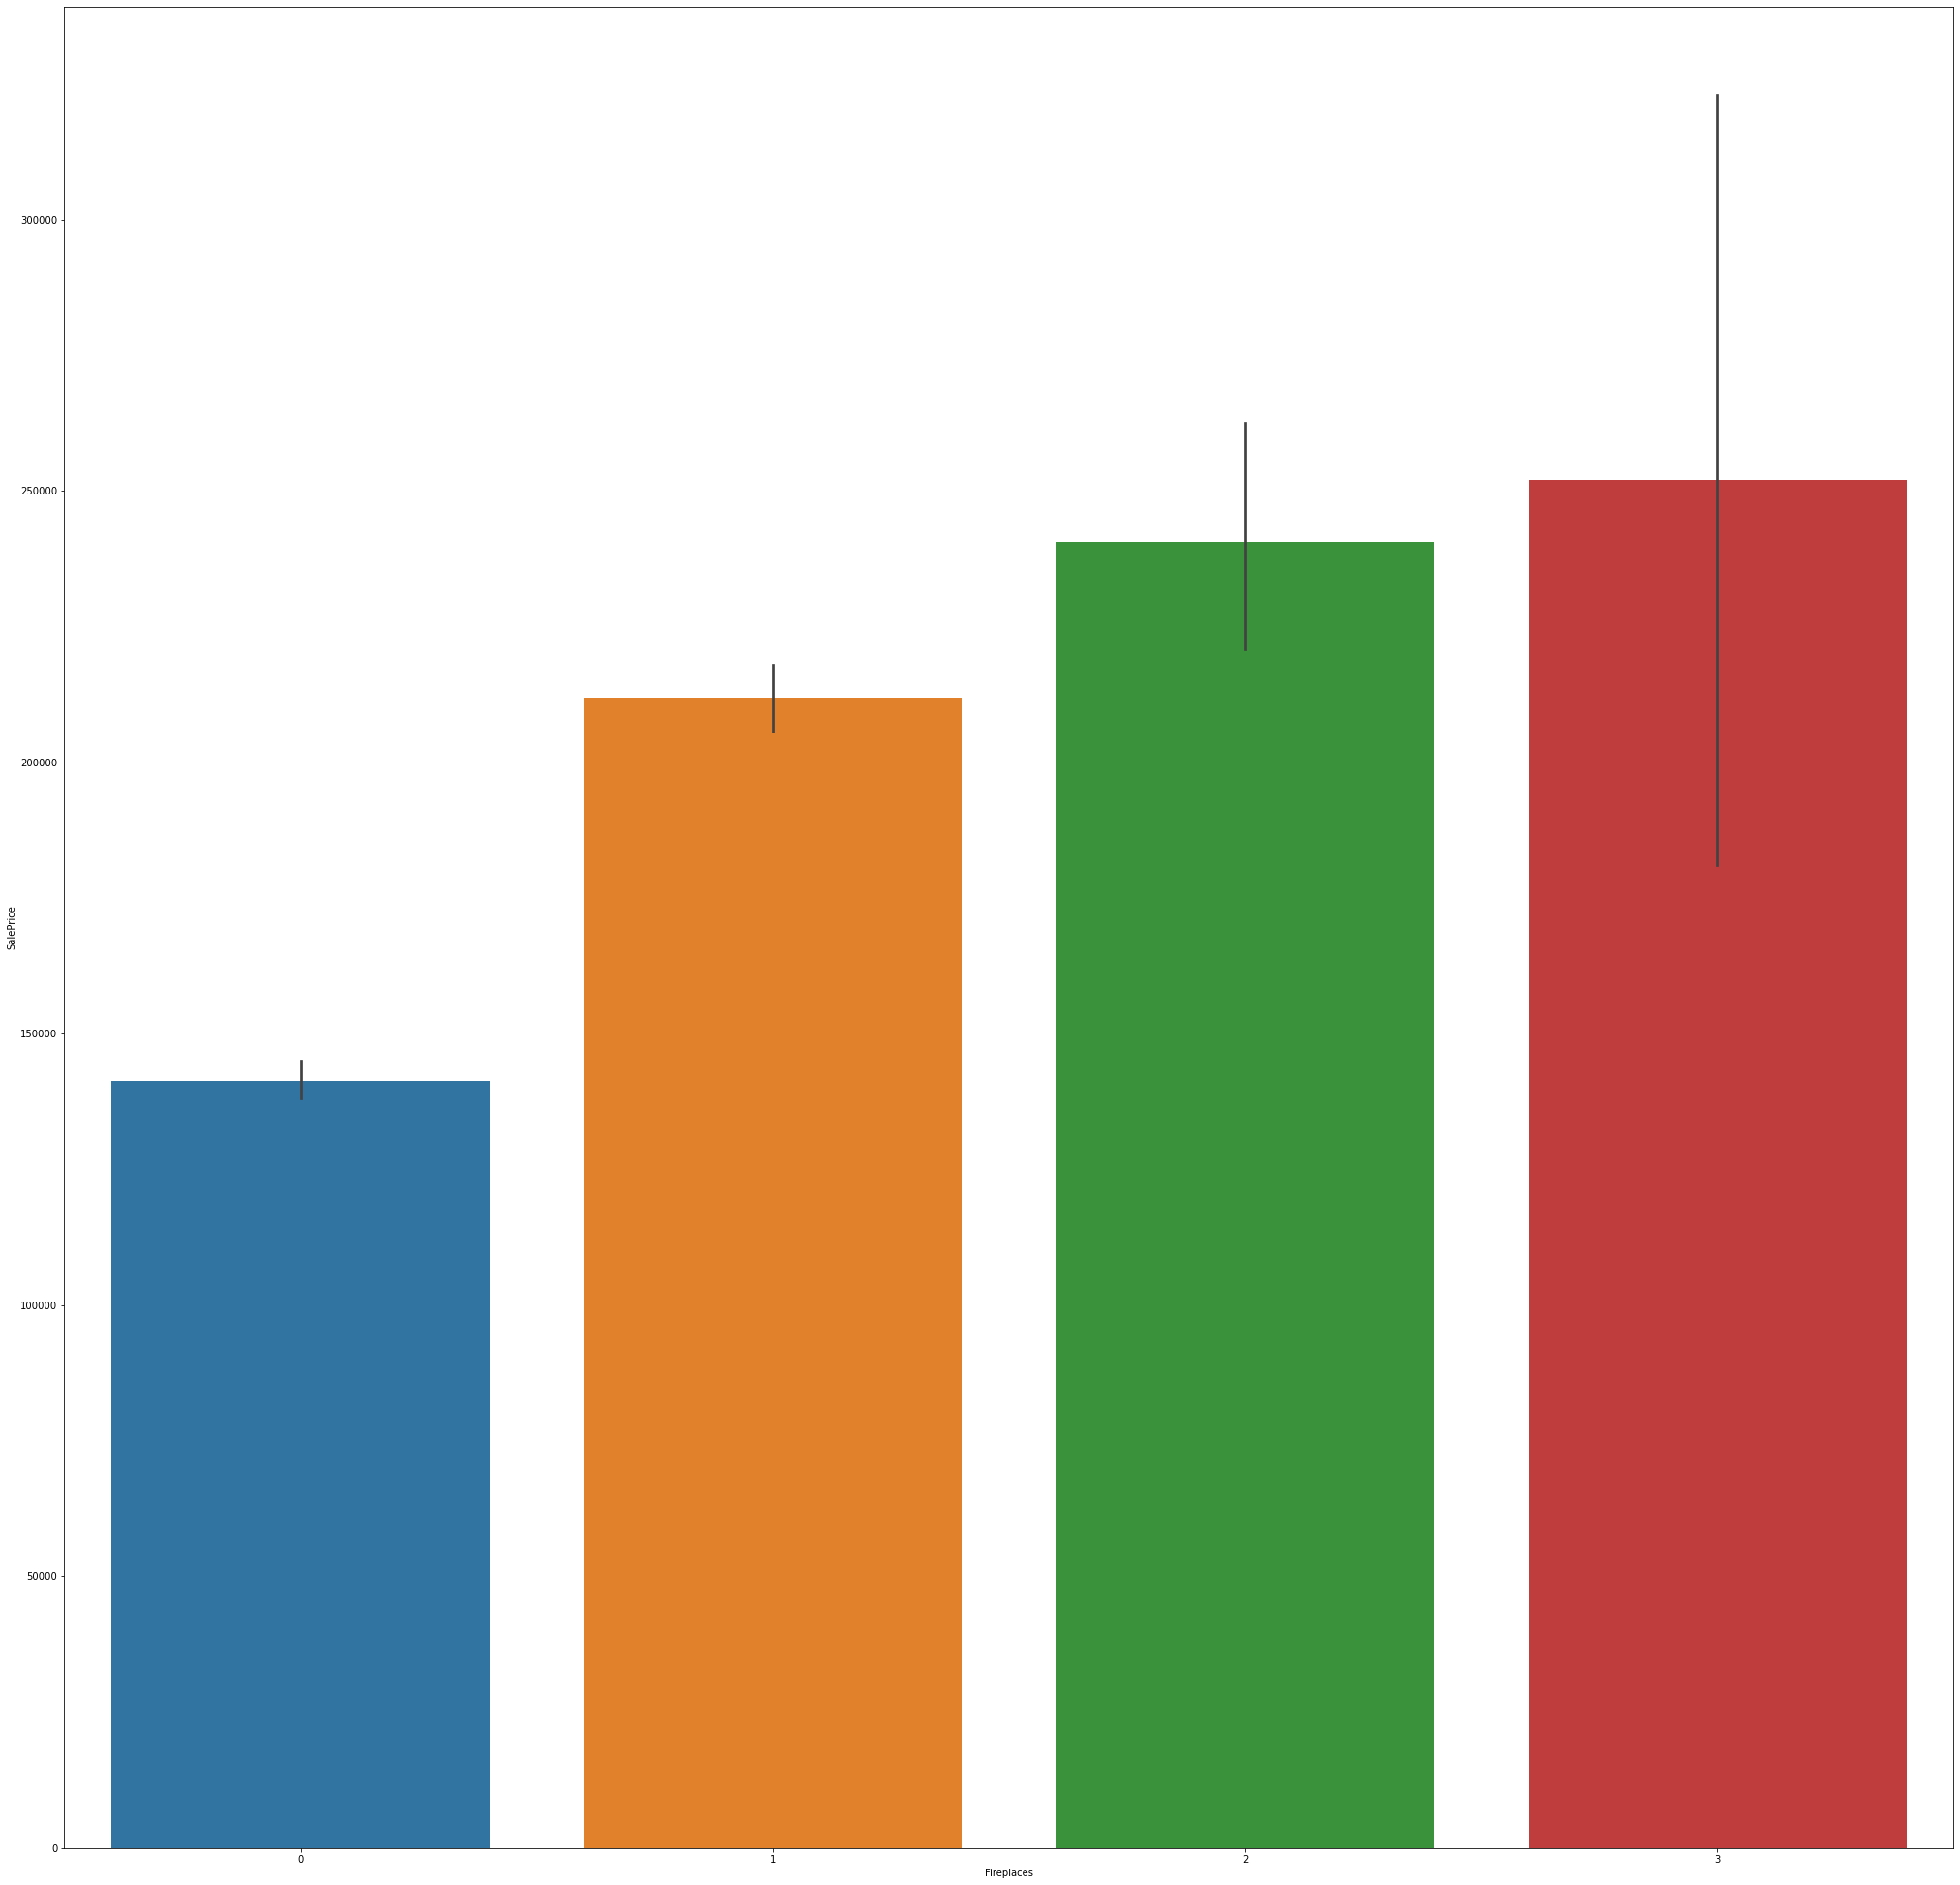

In [23]:
sns.barplot(x='Fireplaces', y='SalePrice', data=house_data)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


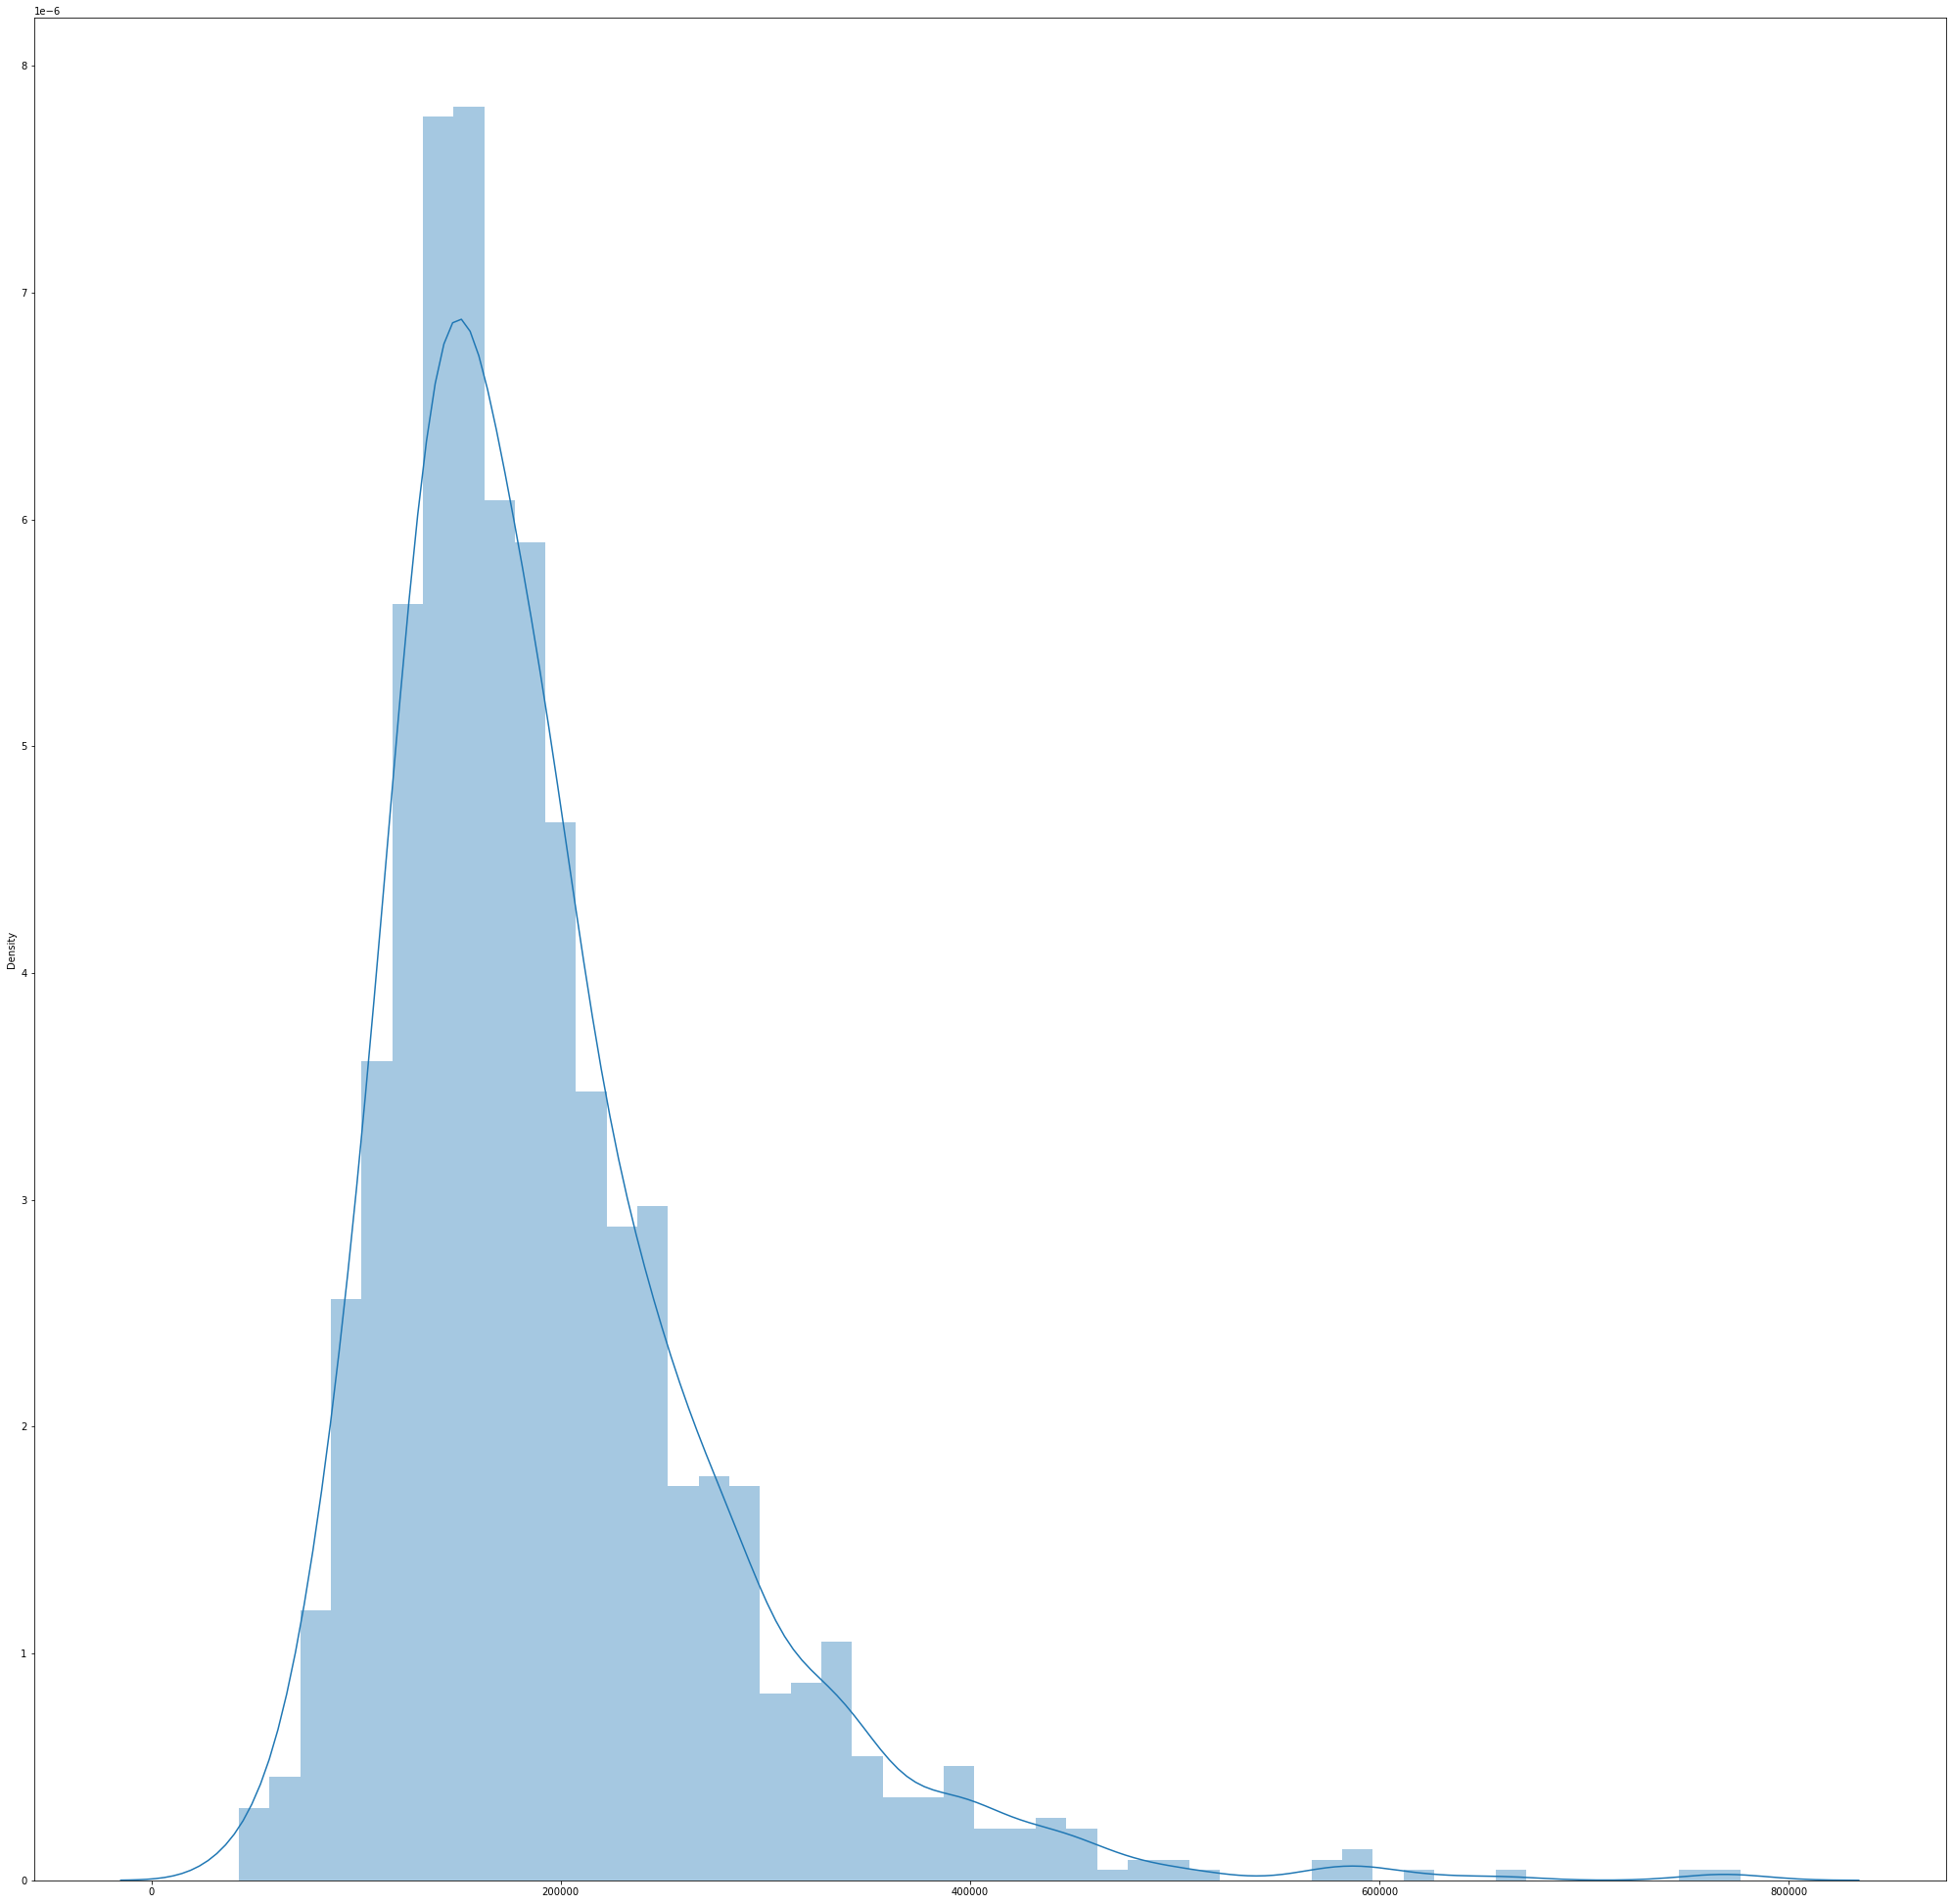

In [27]:
lot_price = house_data['LotArea'] + house_data['SalePrice']
sns.distplot(lot_price).bins= '100'

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

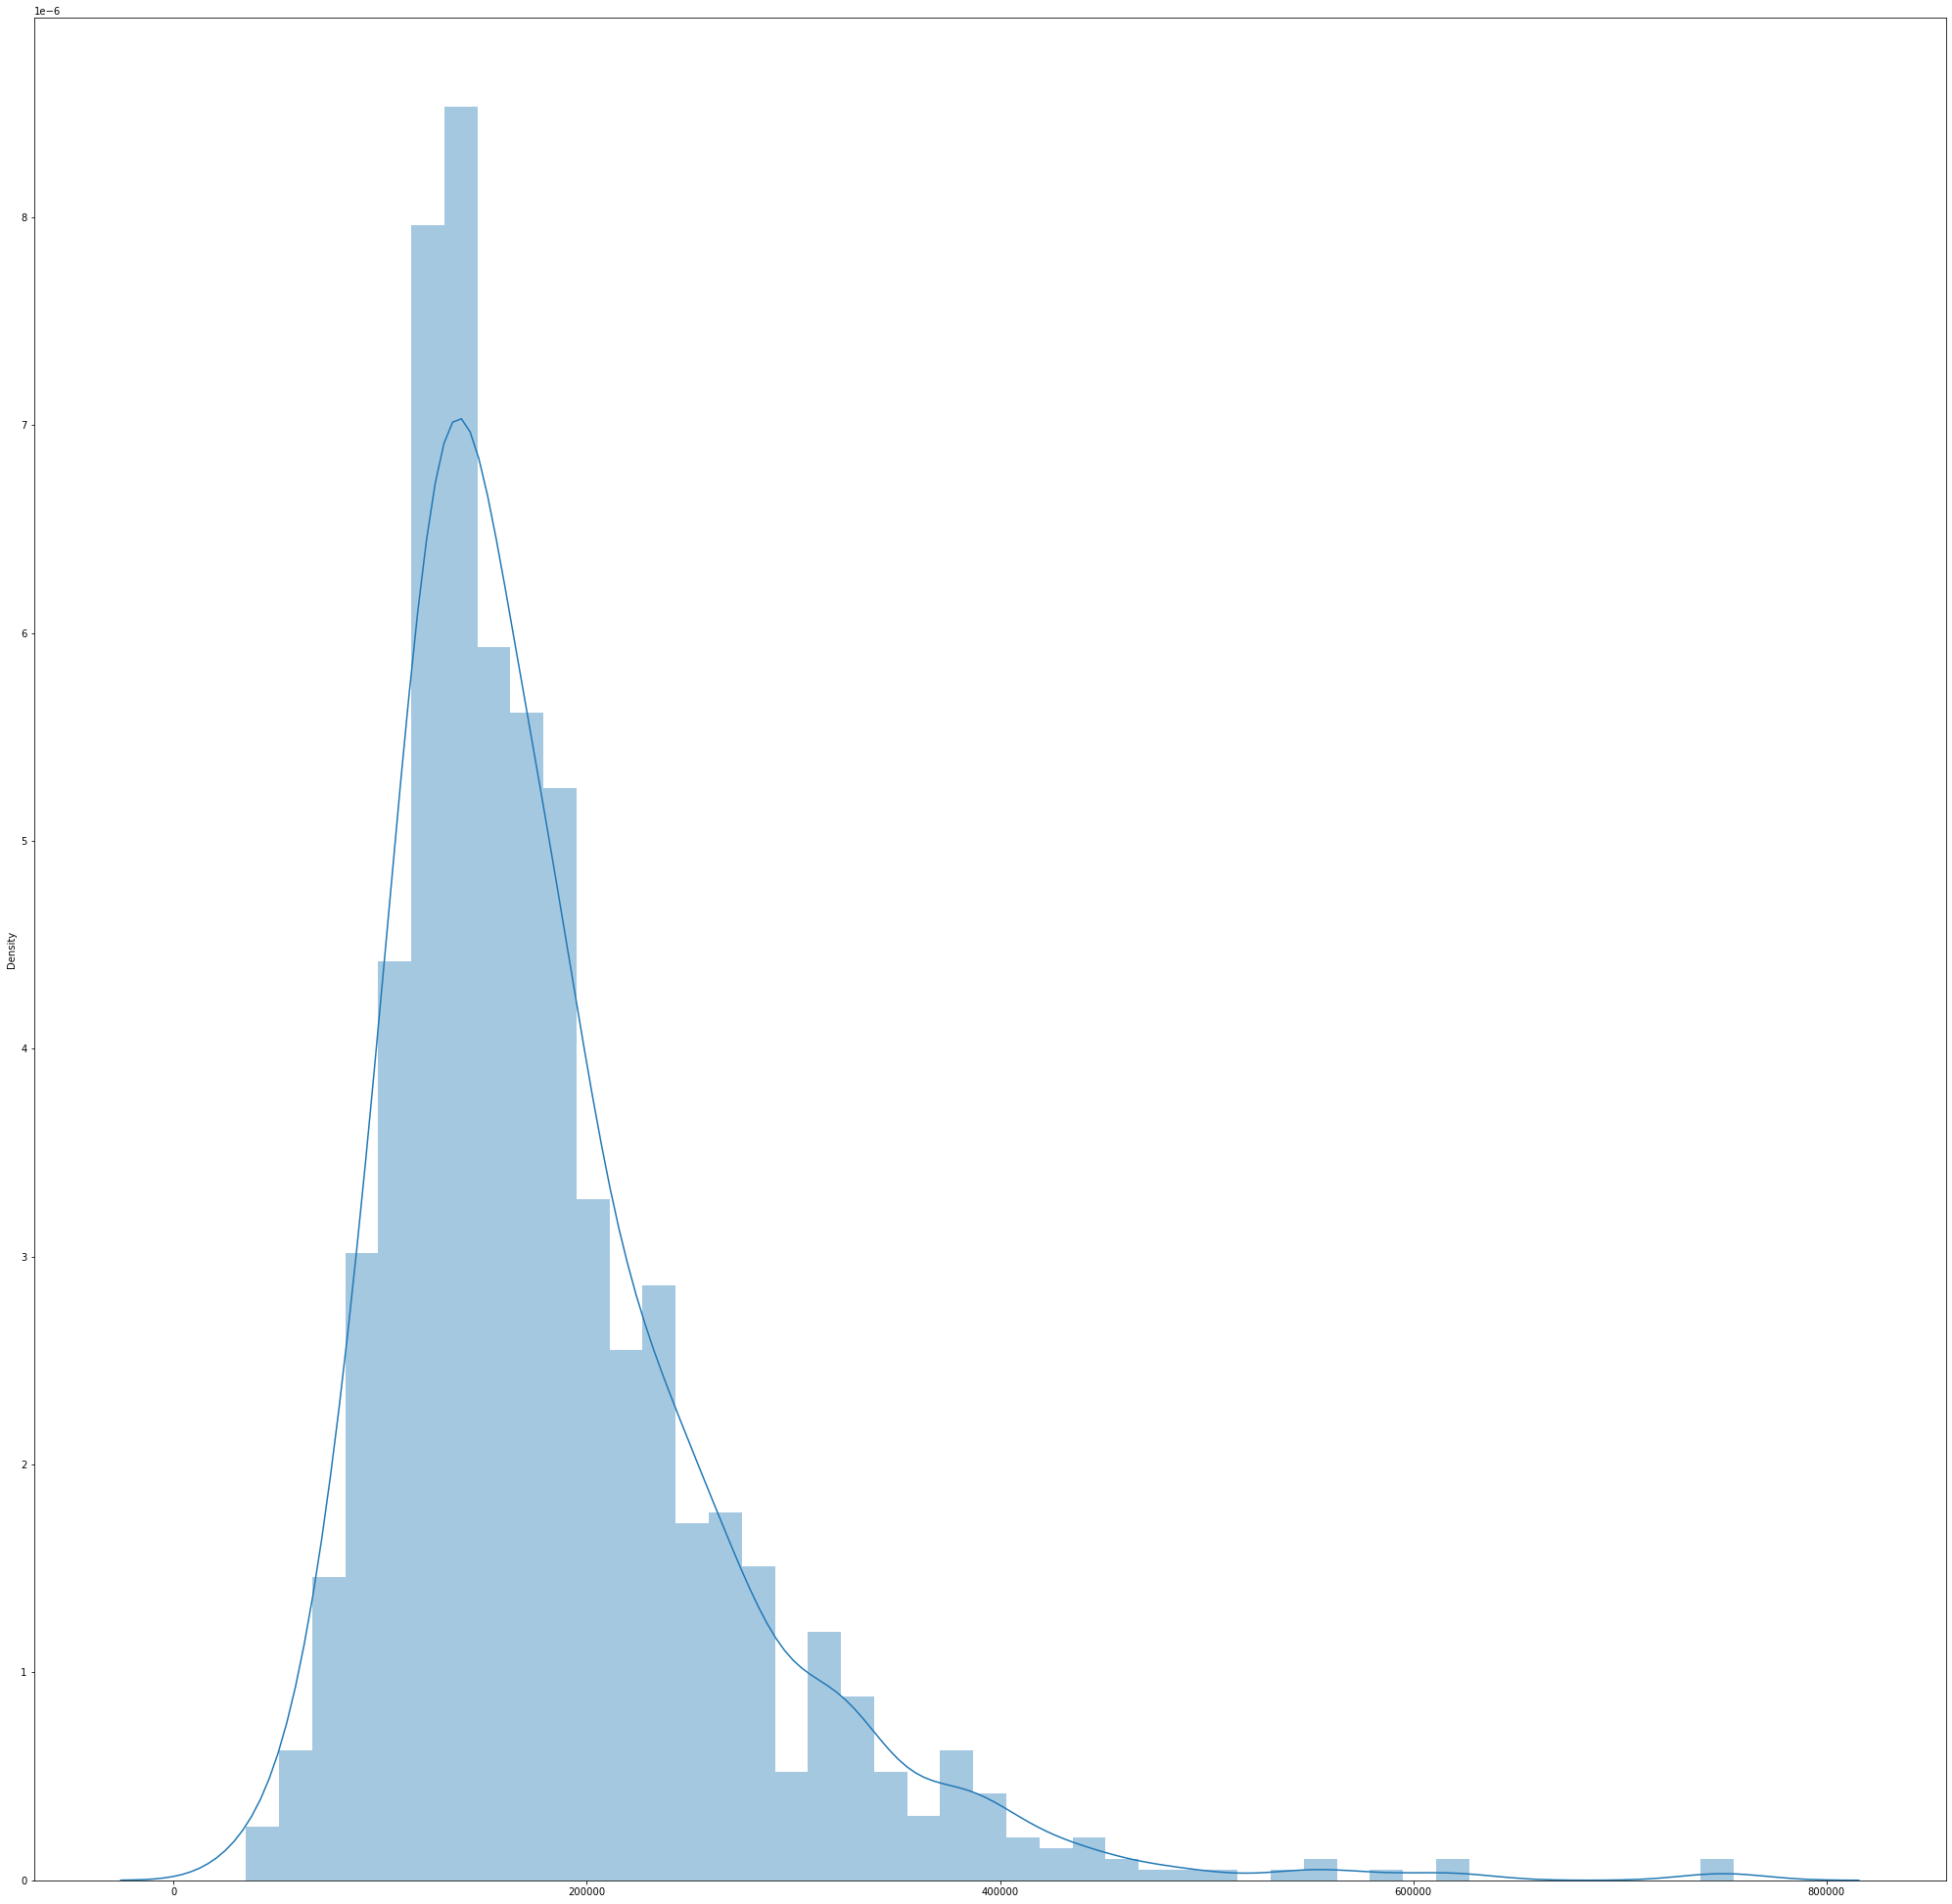

In [25]:
frontage_price = house_data['LotFrontage'] + house_data['SalePrice']
sns.distplot(frontage_price)

**Feature and Prediction Target Split**


In [28]:
features = [x for x in house_data.columns if x not in ['SalePrice']]
X = house_data[features]
y = house_data['SalePrice']

In [29]:
X.columns.to_list()

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [30]:
print(X['YearBuilt'].head())
print(X['YearRemodAdd'].head())

0    2003
1    1976
2    2001
3    1915
4    2000
Name: YearBuilt, dtype: int64
0    2003
1    1976
2    2002
3    1970
4    2000
Name: YearRemodAdd, dtype: int64


In [31]:
print(X['LotArea'].head())
print(X['LotFrontage'].head())

0     8450
1     9600
2    11250
3     9550
4    14260
Name: LotArea, dtype: int64
0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64


In [45]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

In [46]:
X_feat_eng = X.copy()
X_feat_eng['years_since_update'] = X_feat_eng['YearRemodAdd'] - X_feat_eng['YearBuilt']
X_feat_eng['geometry'] = X_feat_eng['LotArea'] / X_feat_eng['LotFrontage']
X_feat_eng['land_topology'] = X_feat_eng['LandSlope'] + '_' + X_feat_eng['LandContour']
X_feat_eng['value_proposition'] = X_feat_eng['YearBuilt'] * X_feat_eng['OverallQual']
X_feat_eng['finished_basement'] = X_feat_eng['BsmtFinSF1'] > 0
X_feat_eng['garage_value'] = X_feat_eng['YearBuilt'] * X_feat_eng['GarageCars']
X_feat_eng['misc_value'] = X_feat_eng['Fireplaces'] + X_feat_eng['OverallQual']

X_feat_eng = X_feat_eng.drop(columns=['GarageCars'])

feature_numerical_cols = [cname for cname in X_feat_eng.columns if 
                X_feat_eng[cname].dtype in ['int64', 'float64']]

feature_categorical_cols = [cname for cname in X_feat_eng.columns if
                    X_feat_eng[cname].nunique() < 50 and 
                    X_feat_eng[cname].dtype in ['object', 'bool']]


feature_numerical_transformer = SimpleImputer(strategy='constant')

feature_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', feature_numerical_transformer, feature_numerical_cols),
        ('cat', feature_categorical_transformer, feature_categorical_cols)
])

feature_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0, monotone_constraints='()',
             n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

feature_clf = Pipeline(steps=[('feature_preprocessor', feature_preprocessor),('feature_model', feature_model)])

feature_X_train, feature_X_valid, feature_y_train, feature_y_valid = train_test_split(X_feat_eng, y, random_state=0)

feature_clf.fit(feature_X_train, feature_y_train, feature_model__verbose=False) 
feature_preds = feature_clf.predict(feature_X_valid)

print('RMSLE:', root_mean_squared_log_error(feature_y_valid, feature_preds))

RMSLE: 0.12206014967168517


In [47]:
X_test = pd.read_csv('test_house.csv')

In [48]:
X_test['years_since_update'] = X_test['YearRemodAdd'] - X_test['YearBuilt']
X_test['geometry'] = X_test['LotArea'] / X_test['LotFrontage']
X_test['land_topology'] = X_test['LandSlope'] + '_' + X_test['LandContour']
X_test['value_proposition'] = X_test['YearBuilt'] * X_test['OverallQual']
X_test['finished_basement'] = X_test['BsmtFinSF1'] > 0
X_test['garage_value'] = X_test['YearBuilt'] * X_test['GarageCars']
X_test['misc_value'] = X_test['Fireplaces'] + X_test['OverallQual']

X_test = X_test.drop(columns=['GarageCars'])

feature_clf.fit(X_feat_eng, y, feature_model__verbose=False)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalf...
                              colsample_bytree=0.

In [49]:
preds = feature_clf.predict(X_test)
output = pd.DataFrame({'Id': X_test.Id,
                       'SalePrice': preds})
output.to_csv('submission_house.csv', index=False)